In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import loadTDT as tdt
from scipy import signal
from scipy.signal import detrend
import statsmodels.formula.api as smf
from scipy.signal import resample
from scipy.signal import medfilt
from scipy.signal import butter
from scipy.signal import filtfilt
from statsmodels import robust
from scipy import ndimage, misc
from scipy.stats import levene, ttest_ind
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
sns.set_context("poster")

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Advanced analysis for behavioral and dopaminergic recordings during defeat
Data can be downloaded from https://figshare.com/articles/dataset/Defeat_Recording_Data/20102681

In [3]:
from util import *

In [4]:
import pickle
alldat = pickle.load(open('../../figures/final_figures/figshare/defeat_recording.p','rb'),encoding='latin')

In [5]:
SI_values = [
 6.618066666666667,
 14.476133333333332,
 18.1407,
 18.263033333333333,
 19.898,
 20.8434,
 23.334766666666667,
 25.3479,
 27.260933333333337,
 27.683566666666668,
 32.021233333333335,
 36.547999999999995,
 40.22933333333334,
 42.087,
 43.46600000000001,
 43.51066666666667,
 43.599333333333334,
 43.855333333333334,
 44.12233333333334,
 46.38,
 47.81466666666666,
 47.99366666666666,
 49.71666666666667,
 52.25266666666667,
 53.898666666666664,
 55.1,
 55.945,
 58.14733333333333,
 64.22000000000001,
 64.743,
 67.49000000000001,
 73.81866666666667]


r2s = [30, 375, 362,  40, 345,  11,  41,  13, 335,  42, 346, 353,
       336,  32,  71, 363,  61, 314,  59, 313, 329, 377, 364, 301, 392,
       332, 376,  29, 340,  60, 312,  70]

# cutoff for resilience based on distribution from controls
RFCUTOFF=13

metadat=pd.read_csv('../../figures/final_figures/figshare/si_sucrose_tt.csv')

## BEHAVIORAL ANALYSIS

In [6]:
## Random forest classifiers
import pickle
rfs = pickle.load(open('../../figures/final_figures/figshare/rfs_2101_new_behaviors.p','rb'),encoding='latin')
rfs_old = pickle.load(open('../../figures/final_figures/figshare/rfs_2101_old_behaviors.p','rb'),encoding='latin')

In [7]:
rf_scores = {}
for k in alldat.keys():
    if 'extracted_features' in alldat[k]:
        rf_scores[k]={}
        X=alldat[k]['extracted_features']
        for b,(rf,c)in rfs.items():
            pred = rf.predict_proba(X)
            rf_scores[k][b]=medfilt(pred.T[0],13)<c
        for b,(rf,c)in rfs_old.items():
            if b == 'fightback':
                continue
            pred = rf.predict_proba(X)
            rf_scores[k][b]=medfilt(pred.T[0],13)<c

In [8]:
rf_totals = {'m':[],'d':[],'t':[],'b':[],'r2s':[],'rb':[]}
fight_check = {'m':[],'d':[],'r2s':[],'rb':[],'F':[],'T':[],'f':[],'a':[],'si':[],'r':[],'R':[]}
for i,m in enumerate(r2s):
    for d in range(1,11):
        if (m,d) not in rf_scores:
            continue
        rf=rf_scores[(m,d)]
        for b,l in rf.items():
            t=l
            rf_totals['b'].append(b)
            rf_totals['m'].append(str(m))
            rf_totals['d'].append(d)
            rf_totals['t'].append(np.sum(t)/len(t))
            rf_totals['r2s'].append(i)
            rf_totals['rb'].append(i>=RFCUTOFF)
        a=rf['attack']
        b=np.logical_and(a,rf['fightback'])
        rf_totals['b'].append('fightWhenAttacked')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF)
        
        a=rf['attack']
        b=np.logical_and(a,rf['runaway'])
        rf_totals['b'].append('fleeWhenAttacked')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF)

        
        fight_check['m'].append(str(m))
        fight_check['d'].append(d)
        fight_check['r2s'].append(i)
        fight_check['rb'].append(i>=RFCUTOFF)
        fight_check['F'].append(np.sum(rf['fightback']))
        fight_check['T'].append(len(t))
        fight_check['f'].append(np.sum(np.logical_and(rf['attack'],rf['fightback'])))
        fight_check['a'].append(np.sum(rf['attack']))
        fight_check['si'].append(SI_values[i])
        fight_check['R'].append(np.sum(rf['runaway']))
        fight_check['r'].append(np.sum(np.logical_and(rf['attack'],rf['runaway'])))
        
fight_check_df=pd.DataFrame(fight_check)
rf_df=pd.DataFrame(rf_totals)
rf_df.m=rf_df.m.astype(int)
rf_df = pd.merge(metadat,rf_df,left_on='Mouse',right_on='m')

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

318
18 13
being attacked 1 1.8364789431215924 0.07655763658932502
19 13
being attacked 2 -0.3881947771463167 0.7006130248312644
19 13
being attacked 3 -1.0447840828260746 0.3044686943891065
19 13
being attacked 4 -0.8930479805915074 0.3789396506576739
19 13
being attacked 5 1.3890603293207702 0.17504032113292045
19 13
being attacked 6 0.2739880280388495 0.7859715633758166
19 12
being attacked 7 0.15808628456341783 0.8754844832549331
19 13
being attacked 8 -0.145104524115474 0.8855988632470736
19 13
being attacked 9 -0.6129782094540722 0.5445101548530582
19 13
being attacked 10 0.5657999895327673 0.5757377451305982
being attacked [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min.

19 13
fighting while attacked 3 0.830616197233677 0.41275230950978736
19 13
fighting while attacked 4 1.2200705002317929 0.2319426974091388
19 13
fighting while attacked 5 0.7384759663551808 0.4659636499310994
19 13
fighting while attacked 6 2.040997123927491 0.05013432834340104
19 12
fighting while attacked 7 2.1722122479893704 0.03815699422678794
19 13
fighting while attacked 8 0.6524931963744353 0.5190519619363099
19 13
fighting while attacked 9 0.827960024827915 0.4142314379902191
19 13
fighting while attacked 10 0.727045952659739 0.47283356883746175
fighting while attacked [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                 

<Figure size 720x720 with 0 Axes>

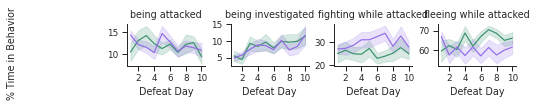

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          42.441
Covariance type:                    robust   Time:                         21:35:46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0859      0.986     12.258      0.000      10.153      14.018
si     

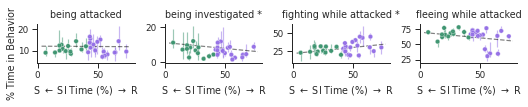

In [40]:
b2tdict={'attack':'being attacked',
     'standing against wall':'standing against wall',
     'fightback':'fighting',
     'runaway':'fleeing',
     'sniffing':'being investigated',
     'freezing':'immobile',
     'approach':'approaching aggressor',
     'fightWhenAttacked':'fighting while attacked',
     'fightWhenNotAttacked': 'fighting while not attacked',
     'notAttackedWhenFight':'not attacked while fighting',
      'fleeWhenAttacked':'fleeing while attacked',
     'freezeWhenAttacked':'immobile while attacked',
      'fleeWhenSniffed':'fleeing while sniffed',
     'freezeWhenSniffed':'immobile while sniffed',
      'fightWhenSniffed':'fighting while sniffed',
       'fleeWhenNotAttackedOrSniffed':'fleeing while not attacked or sniffed',
     'freezeWhenNotAttackedOrSniffed':'immobile while not attacked or sniffed',
      'fightWhenNotAttackedOrSniffed':'fighting while not attacked or sniffed',
        'attackWhenNotFightOrFlee':'not fighting or fleeing while attacked',
     'fightToFleeRatio': 'fight vs flee'}

border=['attack','sniffing','fightWhenAttacked','fleeWhenAttacked']
rf_df_plot=rf_df
rf_df_plot['c']=[b2tdict[b] for b in rf_df_plot.b.values]
rf_df_plot['si']= [SI_values[i] for i in rf_df_plot.r2s.values]
rf_df_plot=rf_df_plot.query('b in %s'%(border))
rf_df_plot['t']=rf_df_plot['t']*100
rf_df_plot['sex']='male'

rf_summary=make_behavior_plots(rf_df_plot,offset=0.5,order=[b2tdict[b] for b in border],
                    ylabel='% Time in Behavior',aspect=0.83,height=1.5)

In [10]:
## t-SNE
saved=pickle.load(open('../../figures/final_figures/figshare/tsne_2101.p','rb'))
X_embedded=saved['training']
mlp2=saved['projection']
labeled_map=saved['map']
e2_test=saved['embeddings']

In [11]:
embeddings2={}
for k in alldat.keys():
    if 'extracted_features' in alldat[k]:
        X=alldat[k]['extracted_features']
        embedded_mlp = mlp2.predict(X)
        embeddings2[k]=embedded_mlp

In [12]:
tsne_dists=[229.70494978266953,
 245.55505578548951,
 245.12842340146145,
 166.58055751288933,
 149.51097837985458,
 250.90124233870606,
 226.49122360206243,
 141.3280762786305,
 96.60278218737608,
 128.60567565443952,
 93.26928011218547,
 175.86329471200276,
 89.84951112059038,
 90.04663779430373,
 203.50069251536658,
 57.43254248517057,
 123.0666217373827,
 92.19272510334693]

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=

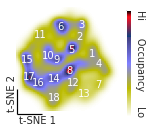

In [13]:
import skimage
import scipy
from skimage.feature import peak_local_max
from skimage.morphology import watershed
sns.set_context("paper")
sns.set_style('dark')
sigma=1.5
percentile=30

X_pred=np.row_stack(e2_test.values())

def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

# Find local maxima as "seeds" for the watershed tranlsform
all_map_density,xe,ye = heatmap(X_pred, bins=50, sigma=sigma)
density_cutoff = np.percentile(all_map_density, percentile)
density_mask = all_map_density > density_cutoff
local_maxes = peak_local_max(all_map_density, indices=False)
local_maxes[np.logical_not(density_mask)] = False
markers, n_peaks = scipy.ndimage.label(local_maxes)

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=True)
labeled_map_viz = labeled_map_viz.astype('float64')

labeled_map2=labeled_map.copy()
for i in range(1,49):
    for j in range(1,49):
        a=labeled_map[i][j]!=labeled_map[i-1][j]
        b=labeled_map[i][j]!=labeled_map[i+1][j]
        c=labeled_map[i][j]!=labeled_map[i][j-1]
        d=labeled_map[i][j]!=labeled_map[i][j+1]
        if a or b or c or d:
            labeled_map2[i][j]=0

viz = all_map_density.copy()


plt.figure(figsize=(2.2,2.2))
im=plt.imshow(viz.T,cmap='gist_stern_r',origin='lower')
xlist=[]
ylist=[]
for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    xlist.append(x)
    ylist.append(y)
    plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,size=10,
            verticalalignment='center',
            horizontalalignment='center',
            color='white')
cbar=plt.colorbar(im,fraction=0.046)
cbar.set_ticks([])
cbar.set_label('Hi      Occupancy     Lo',rotation=-90,va='bottom')

plt.vlines(x=0,ymin=-2,ymax=10,color='k')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
plt.hlines(y=-2,xmin=0,xmax=12,color='k')
plt.text(1,-2.8,'t-SNE 1',size=10,verticalalignment='top')
plt.axis('off')
plt.show()


Plot where random forest behaviors exist in t-SNE space

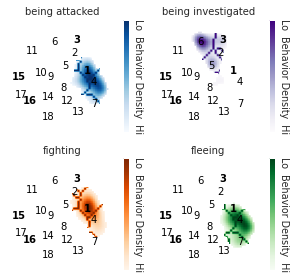

In [14]:
b2p={'fightback':'Oranges', 
     'attack':'Blues', 
     'freezing':'Reds', 
     'runaway':'Greens', 
     'sniffing':'Purples', 
     'approach':'Greys'
}
b2t=[('attack','being attacked'),
     ('sniffing','being investigated'),
     
     ('fightback','fighting'),
     ('runaway','fleeing'),
     ('approach','approaching aggressor'),
     ('freezing','immobile')]
attack_map=np.zeros(1)
sns.set_context("paper")
sns.set_style('dark')
fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(4.2,4))
rc=0
for b,t in b2t[:4]:
    col=int(rc%2)
    row=int(rc/2)
    ax=axs[row][col]
    e=[]
    for k in rf_scores:
        e.append(embeddings2[k][rf_scores[k][b]])
    e=np.row_stack(e)
    z,_,_ = heatmap(e,
                    bins=(xe,ye), sigma=2)
    z[labeled_map_viz==0]=z.max()
    mx=np.ma.masked_array(z, z<np.percentile(z,80))
    im=ax.imshow(mx.T,origin='lower',cmap=b2p[b])
    for i in np.unique((labeled_map).flatten()):
        x=np.where(labeled_map*local_maxes.astype(int)==i)[0]
        y=np.where(labeled_map*local_maxes.astype(int)==i)[1]
        if np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 in [1,3,15,16]:
            ax.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='k', weight='bold')
        else:
            ax.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='k')
    ax.set_title(t,fontsize=10)
    ax.axis('off')
    rc+=1
    if b=='attack':
        attack_map=z
    cbar=plt.colorbar(im,fraction=0.046,ax=ax)
    cbar.set_ticks([])
    cbar.set_label('Lo  Behavior Density  Hi',rotation=-90,va='bottom')

plt.show()

In [15]:
xe,ye=(np.array([-53.31824247, -51.02838956, -48.73853665, -46.44868374,
        -44.15883083, -41.86897791, -39.579125  , -37.28927209,
        -34.99941918, -32.70956627, -30.41971336, -28.12986044,
        -25.84000753, -23.55015462, -21.26030171, -18.9704488 ,
        -16.68059589, -14.39074297, -12.10089006,  -9.81103715,
         -7.52118424,  -5.23133133,  -2.94147842,  -0.6516255 ,
          1.63822741,   3.92808032,   6.21793323,   8.50778614,
         10.79763905,  13.08749197,  15.37734488,  17.66719779,
         19.9570507 ,  22.24690361,  24.53675652,  26.82660944,
         29.11646235,  31.40631526,  33.69616817,  35.98602108,
         38.27587399,  40.56572691,  42.85557982,  45.14543273,
         47.43528564,  49.72513855,  52.01499147,  54.30484438,
         56.59469729,  58.8845502 ,  61.17440311]),
 np.array([-49.13876281, -47.0439975 , -44.9492322 , -42.85446689,
        -40.75970159, -38.66493628, -36.57017098, -34.47540567,
        -32.38064037, -30.28587506, -28.19110976, -26.09634445,
        -24.00157915, -21.90681384, -19.81204854, -17.71728323,
        -15.62251793, -13.52775262, -11.43298732,  -9.33822201,
         -7.24345671,  -5.1486914 ,  -3.0539261 ,  -0.95916079,
          1.13560451,   3.23036982,   5.32513512,   7.41990043,
          9.51466573,  11.60943104,  13.70419634,  15.79896165,
         17.89372695,  19.98849226,  22.08325756,  24.17802287,
         26.27278817,  28.36755348,  30.46231878,  32.55708409,
         34.6518494 ,  36.7466147 ,  38.84138001,  40.93614531,
         43.03091062,  45.12567592,  47.22044123,  49.31520653,
         51.40997184,  53.50473714,  55.59950245]))

map_shape=(50,50)
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)
labels={}
for k,e in embeddings2.items():

    def to_coords(xy):
        
        x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
        y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
        if x >= map_shape[0]:
            x = map_shape[0]-1
        if y >= map_shape[1]:
            y = map_shape[1]-1
        if x < 0:
            x=0
        if y < 0:
            y=0
        return int(x), int(y)
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

In [16]:
cbar_list=['Far                     Close',
           'Far                     Close',
           'Far                     Close',
           'Fast                Slow',
           'Fast                     Slow',
           'Low                     High',
           'Low                     High',
           'Toward             Away',
           'Toward             Away',
           'Fast                Slow',
           'Far                     Close',
           'Far                     Close'
          ]

vars_list = [
"Proximity", 
"swNose-blTTI dist", 
"swNose-blNOSE dist", 
"SW velocity", 
"BL velocity", 
"SW side height", 
"BL side height",
"SW orientaiton",
"BL orientation",
"BL-SW between centroid velocity",
"BL dist to short wall",
"BL dist to long wall"
]

In [17]:
hists = {}
for i in range(len(r2s)):
    m = r2s[i]
    for j in range(10):
        test_key = (m,j+1)
        if test_key not in embeddings2:
            continue
        embedded_mlp=embeddings2[test_key]
        z,_,_ = heatmap(embedded_mlp, bins=(xe,ye), sigma=1.5)
        hists[test_key]=z/z.sum()

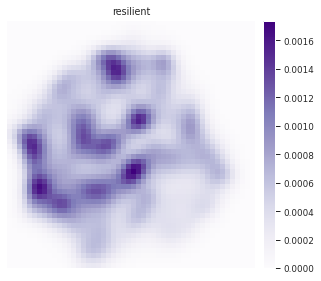

In [18]:
resilient_map=np.zeros(hists[(376,1)].shape)
resilient_maps=[]
for m in r2s[RFCUTOFF:]:
    sub_m=np.zeros(hists[(376,1)].shape)
    for d in range(1,11):
        if (m,d) in hists:
            sub_m += hists[(m,d)]
    resilient_map+=sub_m/sub_m.sum()
    resilient_maps.append(sub_m/sub_m.sum())
resilient_map=resilient_map/resilient_map.sum()
plt.figure()
im=plt.imshow(resilient_map.T,origin='lower',cmap='Purples')
plt.title('resilient')
cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
plt.axis('off')
plt.show()

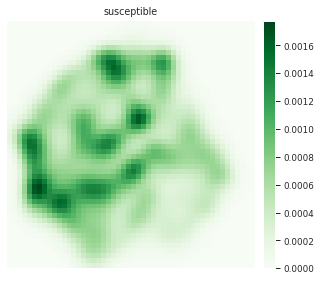

In [19]:
susceptible_map=np.zeros(hists[(376,1)].shape)
susceptible_maps=[]
for m in r2s[:RFCUTOFF]:
    sub_m=np.zeros(hists[(376,1)].shape)
    for d in range(1,11):
        if (m,d) in hists:
            sub_m += hists[(m,d)]
    susceptible_map+=sub_m/sub_m.sum()
    susceptible_maps.append(sub_m/sub_m.sum())
susceptible_map=susceptible_map/susceptible_map.sum()
plt.figure()
im=plt.imshow(susceptible_map.T,origin='lower',cmap='Greens')
plt.title('susceptible')
cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
plt.axis('off')
plt.show()

In [20]:
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list(
        "Custom", [ggp[1],'white',ggp[2]], N=55)

(-0.5, 49.5, -0.5, 49.5)

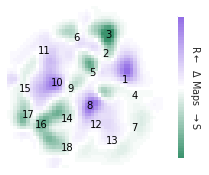

In [21]:
diffmap=susceptible_map-resilient_map
plt.figure(figsize=(3,3))
plt.imshow(-1*diffmap.T,
           cmap=cm,
           vmin=-0.0003,vmax=0.0003,
          origin='lower')
for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1]
    plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
             size=10,
            verticalalignment='center',
            horizontalalignment='center',
            color='k')
cbar=plt.colorbar(fraction=0.04)
cbar.set_label(r'R$\leftarrow$  $\Delta$ Maps  $\rightarrow$S',rotation=-90,va='bottom')
cbar.set_ticks([])
plt.axis('off')

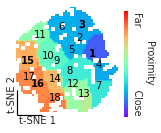

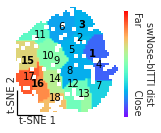

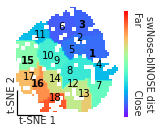

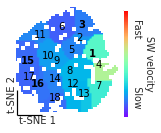

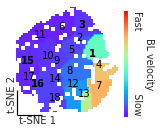

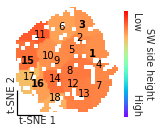

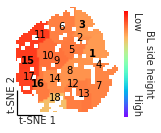

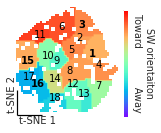

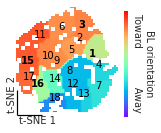

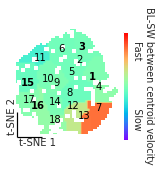

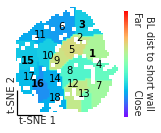

In [22]:
sns.set_context("paper")
sns.set_style("dark")
for j in range(len(vars_list)-1):
    plt.figure(figsize=(2.2,2.1))
    z=np.zeros(labeled_map.shape)
    for i in np.unique(labeled_map.flatten()):
        if i in range(1,19):
            x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
            y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
            if np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 in [1,3,15,16]:
                plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                         size=10,
                        verticalalignment='center',
                        horizontalalignment='center',
                        color='k', weight='bold')
            else:
                plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                         size=10,
                        verticalalignment='center',
                        horizontalalignment='center',
                        color='k')
            ds=[]
            for k in embeddings2:
                ds.append(alldat[k]['extracted_features'][labels[k]==i,j])
            z[np.where(labeled_map.astype(int)==int(i))[0],np.where(labeled_map.astype(int)==int(i))[1]]=np.mean(np.concatenate(ds))


    mx=np.ma.masked_array(z, np.abs(diffmap)<np.percentile(np.abs(diffmap),30))
    im=plt.imshow(mx.T,origin='lower',
                cmap='rainbow',vmin=-1,vmax=1)

    plt.vlines(x=0,ymin=-2,ymax=10,color='k')
    plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
    plt.hlines(y=-2,xmin=0,xmax=12,color='k')
    plt.text(1,-2.5,'t-SNE 1',size=10,va='top')

    cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
    cbar.set_ticks([])
    cbar.set_label(vars_list[j]+'\n'+cbar_list[j],rotation=-90,va='bottom')
    plt.axis('off')
    plt.show()

In [23]:
ms = []
ds = []
ls = []
ts = []
r2sc=[]
rbs=[]
r2s_i={m:np.where(np.array(r2s)==m)[0][0] for m in r2s}
for m,d in labels.keys():
    if m not in r2s:
        continue
    for l in range(1,19):
        ls.append(l)
        ts.append(np.sum(labels[(m,d)]==l)/len(labels[m,d])*100)
        ms.append(m)
        ds.append(d)
        rbs.append(r2s_i[m]>=RFCUTOFF)
        r2sc.append(r2s_i[m])

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['d_centered'] = dat['d']-dat['d'].unique().mean()
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

318
18 13
t-SNE 1 1 2.2853298859251536 0.029791136032837416
19 13
t-SNE 1 2 0.013678043138026875 0.989177400530386
19 13
t-SNE 1 3 0.8344356571419635 0.41063115951121953
19 13
t-SNE 1 4 0.9700406872175612 0.33978256835787657
19 13
t-SNE 1 5 1.770191728537627 0.08685855883441675
19 13
t-SNE 1 6 1.9363854936724298 0.062290814468724934
19 12
t-SNE 1 7 1.6266801708725942 0.1146238818900565
19 13
t-SNE 1 8 0.4852606268900529 0.6310164754950967
19 13
t-SNE 1 9 0.6383959224105797 0.5280597705569003
19 13
t-SNE 1 10 1.3769995161671862 0.17870157624665448
t-SNE 1 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equation

19 13
t-SNE 3 3 -0.5116752208752537 0.6126243207445998
19 13
t-SNE 3 4 -2.5546792383578336 0.0159429725691543
19 13
t-SNE 3 5 -1.5849209041073469 0.12347044122512738
19 13
t-SNE 3 6 1.1431347435406247 0.2620233405268148
19 12
t-SNE 3 7 -0.7497862767781126 0.45942329636532353
19 13
t-SNE 3 8 1.6226847759334566 0.11512036434282996
19 13
t-SNE 3 9 -1.6322417701054373 0.11308277474147388
19 13
t-SNE 3 10 -2.269271104578109 0.030605132062156315
t-SNE 3 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:   

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          19.392
Covariance type:                    robust   Time:                         21:19:58
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.5012      0.682      9.539      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           1.479
Covariance type:                    robust   Time:                         21:19:59
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.2499      0.186     12.066      0.00

18 13
t-SNE 9 1 0.9259258559082818 0.36212632611717255
19 13
t-SNE 9 2 -0.328193349850506 0.7450452069727493
19 13
t-SNE 9 3 -0.805141106905791 0.4270737195124129
19 13
t-SNE 9 4 -0.3952571374791523 0.6954497327717543
19 13
t-SNE 9 5 -1.0048952535203222 0.3229842424644729
19 13
t-SNE 9 6 0.8633882843971296 0.3947744147056029
19 12
t-SNE 9 7 -2.0465468804340743 0.04986209670635554
19 13
t-SNE 9 8 0.9349576456306464 0.35727543247706195
19 13
t-SNE 9 9 -0.24756315229537676 0.8061589772936624
19 13
t-SNE 9 10 0.5738402043537205 0.5703535212890796
t-SNE 9 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   

<Figure size 720x720 with 0 Axes>

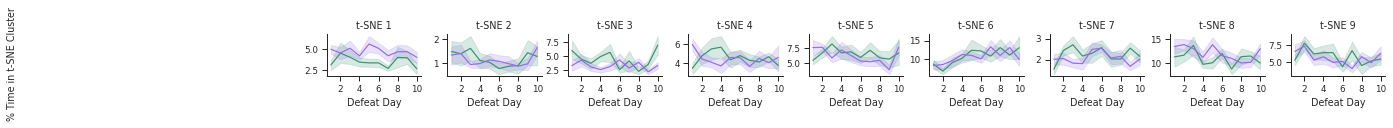

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           9.003
Covariance type:                    robust   Time:                         21:20:01
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5030      0.622      4.022      0.000       1.283       3.723
si     

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          31.725
Covariance type:                    robust   Time:                         21:20:02
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6097      1.579      7.984      0.000       9.514      15.705
si     

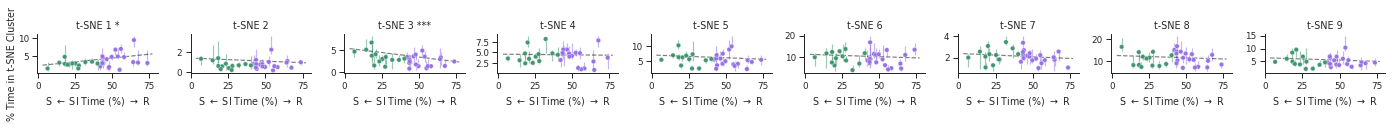

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['d_centered'] = dat['d']-dat['d'].unique().mean()
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

318
18 13
t-SNE 10 1 0.2895426073964196 0.7742262297243137
19 13
t-SNE 10 2 0.43031306271560404 0.6700435607763404
19 13
t-SNE 10 3 1.028894952056701 0.3117535571779878
19 13
t-SNE 10 4 1.8669955114041217 0.07170220205561144
19 13
t-SNE 10 5 0.6950559103558844 0.4923691097681514
19 13
t-SNE 10 6 -0.39735004223699333 0.6939224419970788
19 12
t-SNE 10 7 0.834493343532623 0.4108248701417828
19 13
t-SNE 10 8 0.14807596174666313 0.8832736218725965
19 13
t-SNE 10 9 2.039881736071349 0.05025207038616903
19 13
t-SNE 10 10 0.7107158914787997 0.4827495249220348
t-SNE 10 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Eq

19 13
t-SNE 12 4 0.8318447060521197 0.4120693098452257
19 13
t-SNE 12 5 0.658427218712674 0.5152853411325686
19 13
t-SNE 12 6 -1.0025495579543462 0.3240966067167539
19 12
t-SNE 12 7 -1.2099212863267075 0.2360796335836699
19 13
t-SNE 12 8 0.9009294792849831 0.37480183853857973
19 13
t-SNE 12 9 -1.0148683397293483 0.3182840775457598
19 13
t-SNE 12 10 0.5481504736976239 0.5876446490797823
t-SNE 12 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Indepe

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          18.460
Covariance type:                    robust   Time:                         21:20:10
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.0498      0.526     15.293      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          13.052
Covariance type:                    robust   Time:                         21:20:10
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.7495      0.418     18.554      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           7.301
Covariance type:                    robust   Time:                         21:20:11
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.7648      0.409      9.214      0.00

<Figure size 720x720 with 0 Axes>

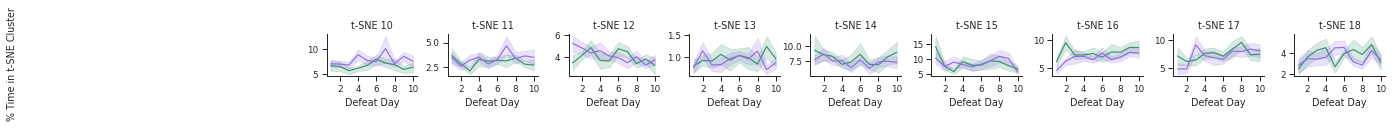

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          21.071
Covariance type:                    robust   Time:                         21:20:12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6033      0.715      7.842      0.000       4.203       7.004
si     

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          13.405
Covariance type:                    robust   Time:                         21:20:12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9382      0.728     10.909      0.000       6.512       9.364
si     

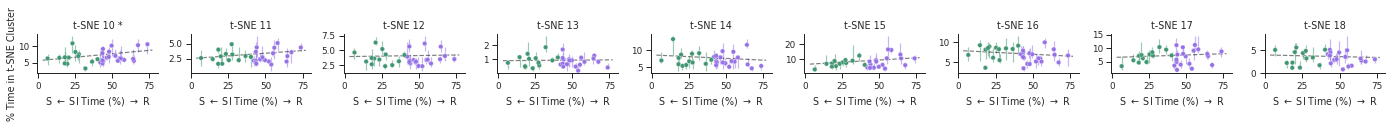

In [24]:
# Clusters labeled in order of distance
df=pd.DataFrame({'m':ms,'d':ds,'t':ts,
                 'c':[np.where(np.argsort(tsne_dists)==int(t)-1)[0][0]+1 for t in ls],
                 'r2s':r2sc,'rb':rbs})
df['sex']='male'
df['si']=[SI_values[i] for i in df.r2s]
df_plt=df.query('c in %s'%([1,2,3,4,5,6,7,8,9]))
df_plt['c']=['t-SNE '+str(c) for c in df_plt.c]
tsne_df1=make_behavior_plots(df_plt,offset=0.5,ylabel='% Time in t-SNE Cluster',height=1.5,aspect=0.7)


df_plt=df.query('c in %s'%([10,11,12,13,14,15,16,17,18]))

df_plt['c']=['t-SNE '+str(c) for c in df_plt.c]
tsne_df2=make_behavior_plots(df_plt,offset=0.5,ylabel='% Time in t-SNE Cluster',height=1.5,aspect=0.7)

Decode resilience category by t-SNE behavior occupancies (logistic regression)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['d_centered'] = dat['d']-dat['d'].unique().mean()
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

318
18 13
t-SNE 1 1 -0.9794501726476246 0.3354583610418669
19 13
t-SNE 1 2 -0.030459443652819166 0.9759023779526992
19 13
t-SNE 1 3 1.261878146510836 0.2167156425936017
19 13
t-SNE 1 4 -0.4764272690792774 0.6372218054767114
19 13
t-SNE 1 5 -0.2599548256406712 0.7966744564680102
19 13
t-SNE 1 6 0.12719706587803808 0.8996331882249817
19 12
t-SNE 1 7 0.013499334919613016 0.9893218599702793
19 13
t-SNE 1 8 0.5464098773730512 0.5888253664704293
19 13
t-SNE 1 9 0.8844755952948634 0.3834735801659962
19 13
t-SNE 1 10 -0.7198940853899414 0.4771617762647504
t-SNE 1 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equatio

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          13.052
Covariance type:                    robust   Time:                         21:20:19
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.7495      0.418     18.554      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          21.239
Covariance type:                    robust   Time:                         21:20:20
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.5652      0.455     14.436      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          18.460
Covariance type:                    robust   Time:                         21:20:21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.0498      0.526     15.293      0.00

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          47.759
Covariance type:                    robust   Time:                         21:20:21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.6704      0.824     12.957      0.00

<Figure size 720x720 with 0 Axes>

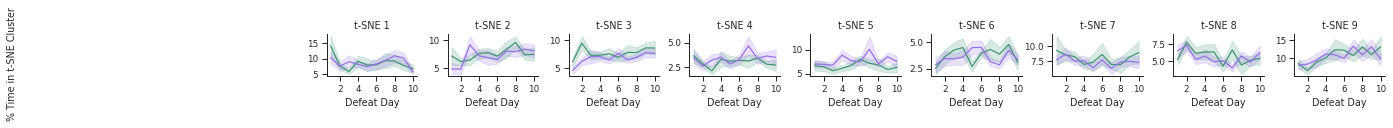

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          54.914
Covariance type:                    robust   Time:                         21:20:22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1168      1.306      4.684      0.000       3.557       8.676
si     

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          18.372
Covariance type:                    robust   Time:                         21:20:23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5162      0.902      9.446      0.000       6.749      10.283
si     

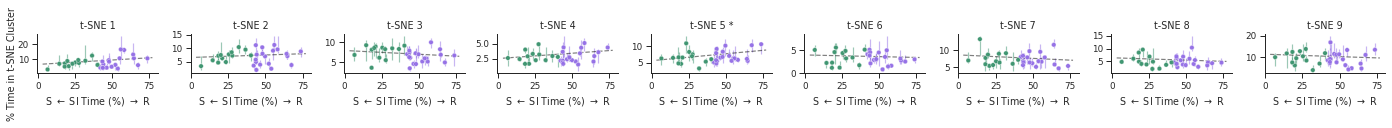

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['d_centered'] = dat['d']-dat['d'].unique().mean()
/mnt/cup/labs/falkner/willmore/csds/analysis/QuantifyingDefeat/FigureAnalysis/util.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

318
18 13
t-SNE 10 1 0.835768669343175 0.41011854940289705
19 13
t-SNE 10 2 1.2114751844822942 0.23516993493016963
19 13
t-SNE 10 3 -0.22817104028200214 0.8210613765979395
19 13
t-SNE 10 4 0.9539229865601534 0.34774626239851825
19 13
t-SNE 10 5 1.6437020519189176 0.1106788524092798
19 13
t-SNE 10 6 -0.22600557267319338 0.8227298212197516
19 12
t-SNE 10 7 1.1085539599817467 0.276731930448791
19 13
t-SNE 10 8 -0.6776357075090678 0.5031957069449535
19 13
t-SNE 10 9 -0.965060325021764 0.3422301321180191
19 13
t-SNE 10 10 1.587821244251199 0.12281198595902101
t-SNE 10 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating

19 13
t-SNE 12 4 0.8318447060521197 0.4120693098452257
19 13
t-SNE 12 5 0.658427218712674 0.5152853411325686
19 13
t-SNE 12 6 -1.0025495579543462 0.3240966067167539
19 12
t-SNE 12 7 -1.2099212863267075 0.2360796335836699
19 13
t-SNE 12 8 0.9009294792849831 0.37480183853857973
19 13
t-SNE 12 9 -1.0148683397293483 0.3182840775457598
19 13
t-SNE 12 10 0.5481504736976239 0.5876446490797823
t-SNE 12 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Indepe

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          15.279
Covariance type:                    robust   Time:                         21:20:31
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.4728      0.333     13.447      0.00

19 13
t-SNE 16 3 0.8344356571419635 0.41063115951121953
19 13
t-SNE 16 4 0.9700406872175612 0.33978256835787657
19 13
t-SNE 16 5 1.770191728537627 0.08685855883441675
19 13
t-SNE 16 6 1.9363854936724298 0.062290814468724934
19 12
t-SNE 16 7 1.6266801708725942 0.1146238818900565
19 13
t-SNE 16 8 0.4852606268900529 0.6310164754950967
19 13
t-SNE 16 9 0.6383959224105797 0.5280597705569003
19 13
t-SNE 16 10 1.3769995161671862 0.17870157624665448
t-SNE 16 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:

19 13
t-SNE 18 10 0.5770182332671425 0.5682322895352264
t-SNE 18 [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           9.615
Covariance type:                    robust   Time:                         21:20:32
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

<Figure size 720x720 with 0 Axes>

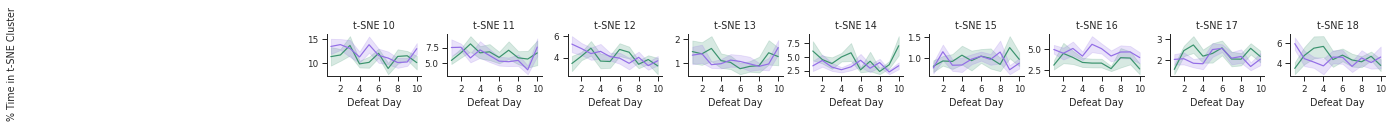

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                          31.725
Covariance type:                    robust   Time:                         21:20:33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6097      1.579      7.984      0.000       9.514      15.705
si     

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  318
Model:                                 GEE   No. clusters:                       32
Method:                        Generalized   Min. cluster size:                   9
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           9.003
Covariance type:                    robust   Time:                         21:20:34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5030      0.622      4.022      0.000       1.283       3.723
si     

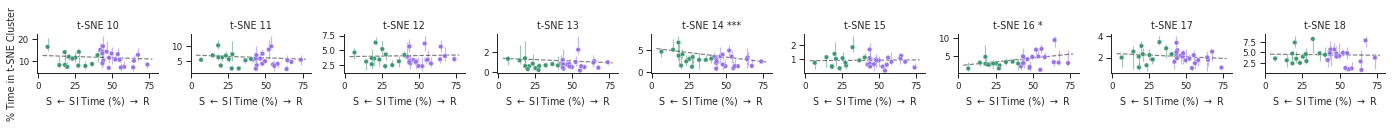

In [25]:
df=pd.DataFrame({'m':ms,'d':ds,'t':ts,
                 'c':ls,
                 'r2s':r2sc,'rb':rbs})
df['sex']='male'
df['si']=[SI_values[i] for i in df.r2s]
df_plt=df.query('c in %s'%([1,2,3,4,5,6,7,8,9]))
df_plt['c']=['t-SNE '+str(c) for c in df_plt.c]
tsne_df1=make_behavior_plots(df_plt,offset=0.5,ylabel='% Time in t-SNE Cluster',height=1.5,aspect=0.7)


df_plt=df.query('c in %s'%([10,11,12,13,14,15,16,17,18]))

df_plt['c']=['t-SNE '+str(c) for c in df_plt.c]
tsne_df2=make_behavior_plots(df_plt,offset=0.5,ylabel='% Time in t-SNE Cluster',height=1.5,aspect=0.7)

In [26]:
test=pd.pivot_table(pd.concat([tsne_df1,tsne_df2]),values='t',index=['m','rb'],columns='c')
testrb=np.array([int(i[1]) for i in test.index])

testols=pd.merge(test,
                 metadat,
                                    left_on='m',right_on='Mouse')
import statsmodels.api as sm
X=testols[['t-SNE %d'%(i) for i in range(1,19)]]
X = sm.add_constant(X)

In [27]:
from sklearn.feature_selection import chi2

testols=pd.merge(test,metadat,left_on='m',right_on='Mouse')
testrb=np.array([int(v=='resilient') for v in testols.resilience])
chi,p=chi2(testols[['t-SNE %d'%(i) for i in range(1,19)]],testrb)
scale=np.array([1-2*((np.mean(testols.loc[testrb==0,'t-SNE %d'%(i)])-np.mean(testols.loc[testrb==1,'t-SNE %d'%(i)]))<0) for i in range(1,19)])

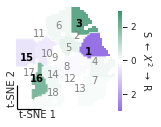

In [28]:
sns.set_context("paper")
sns.set_style("dark")
cm = LinearSegmentedColormap.from_list(
        "Custom", [ggp[2],'white',ggp[1]], N=55)
plt.figure(figsize=(2.2,2.1))
z=np.zeros(labeled_map.shape)
for i in np.unique(labeled_map.flatten()):
    if i in range(1,19):
        x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
        y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
        if np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 in [1,3,15,16]:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='k', weight='bold')
        else:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,
                     size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey')
        val=chi[int(i)-1]*scale[int(i)-1]
        z[np.where(labeled_map.astype(int)==int(i))[0],np.where(labeled_map.astype(int)==int(i))[1]]=val


mx=np.ma.masked_array(z, np.abs(diffmap)<np.percentile(np.abs(diffmap),20))
im=plt.imshow(mx.T,origin='lower',vmin=-3,vmax=3,
            cmap=cm)

plt.vlines(x=0,ymin=-2,ymax=10,color='k')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
plt.hlines(y=-2,xmin=0,xmax=12,color='k')
plt.text(1,-2.5,'t-SNE 1',size=10,va='top')

cbar=plt.colorbar(im,fraction=0.048,orientation='vertical',pad=0.02)
cbar.set_ticks([2,0,-2])
cbar.set_ticklabels([2,0,2])
cbar.set_label(r'S $\leftarrow$ $X^2$ $\rightarrow$ R',rotation=-90,va='bottom')
plt.axis('off')
plt.show()

In [28]:
import statsmodels.api as sm
X=testols[['t-SNE %d'%(i) for i in range(1,18)]]
X = sm.add_constant(X)
len(X)

32

In [32]:
## Logistic regression of R/S by t-SNE behavior cluster occupancy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut

models=[]
clusts=[]
X=X.values
allacc=[]
ns = 4

reductions=[]

loo = LeaveOneOut()
y=testols['SI_time'].values<41.9
loo.get_n_splits(X)
accuracy=[]
shuffle=[]
rbrandom=testrb.copy()
np.random.shuffle(rbrandom)
incorrects=[]
incorrectm=[]

for train_index, test_index in loo.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    r=np.argsort(chi2(X_train,y_train)[0])[-ns:]
    print(r)
    reductions.append(r)

    clf = LogisticRegression(max_iter=5000,class_weight='balanced',penalty='none').fit(X_train[:,r], y_train)

    accuracy.append(clf.predict(X_test[:,r])==y_test)
    if clf.predict(X_test[:,r])!=y_test:
        incorrects.append(y_test)
        incorrectm.append(test.index.values[test_index])
    shuffle.append(clf.predict(X_test[:,r])==rbrandom[test_index])
    models.append(clf)
    clusts.append(r)
    print(test_index,clf.predict(X_test[:,r])==y_test)
print(np.sum(accuracy)/len(X))

allacc.append(np.sum(accuracy)/len(X))

[ 5  3 14 16]
[0] [ True]
[ 5  3 14 16]
[1] [ True]
[ 5 14  3 16]
[2] [ True]
[10 14  3 16]
[3] [ True]
[ 1  3 14 16]
[4] [False]
[18  3 14 16]
[5] [ True]
[ 5  3 14 16]
[6] [False]
[ 5 14  3 16]
[7] [ True]
[ 1  3 14 16]
[8] [ True]
[ 5 16  3 14]
[9] [ True]
[ 1  3 14 16]
[10] [False]
[ 9  3 14 16]
[11] [ True]
[ 1  3 14 16]
[12] [ True]
[ 1  3 16 14]
[13] [ True]
[ 1  3 14 16]
[14] [ True]
[ 1  3 14 16]
[15] [ True]
[ 1  3 14 16]
[16] [ True]
[ 5  3 14 16]
[17] [False]
[ 5  3 14 16]
[18] [ True]
[ 1  3 16 14]
[19] [ True]
[ 1  3 14 16]
[20] [ True]
[ 7  3 14 16]
[21] [ True]
[ 1  3 16 14]
[22] [False]
[ 1  3 14 16]
[23] [ True]
[ 1  3 14 16]
[24] [ True]
[ 6 14  3 16]
[25] [False]
[ 1 14  3 16]
[26] [ True]
[ 1  3 14 16]
[27] [ True]
[ 1  3 14 16]
[28] [ True]
[ 5  3 14 16]
[29] [ True]
[ 1  3 14 16]
[30] [ True]
[ 1  3 16 14]
[31] [ True]
0.8125


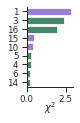

In [33]:
labels_order=np.array([np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1 for i in range(1,19)])
sns.set_style("ticks")
f,ax=plt.subplots(1,1,figsize=(1.2,1.8))
sns.barplot(x=chi[(np.argsort(chi)[::-1])],y=['i'+str(i) for i in np.arange(18)],
            palette=[ggp[int(scale[i]!=-1)*2-1] for i in np.argsort(chi)[::-1]])
plt.ylim(8.5,-0.5)
ax.set_yticklabels(labels_order[(np.argsort(chi)[::-1])])
sns.despine()
plt.xlabel('$\chi^2$',va='center')
plt.show()

In [34]:
from statsmodels.stats.proportion import proportions_ztest
print(proportions_ztest(np.sum(accuracy),len(X),value=0.5,alternative='larger'))

(4.529108136578382, 2.961658995156094e-06)


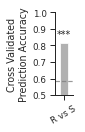

In [35]:
from statsmodels.stats.proportion import proportions_ztest

sns.set_style('ticks')
plt.figure(figsize=(1.2,1.9))
plt.bar(x=['R vs S'],height=[0.8125],
        color='darkgrey',alpha=0.9)
plt.ylim(0.5,1)
plt.xlim(-0.8,0.8)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0])

plt.axhline(y=0.5-0.085,linestyle='--',color='grey',alpha=0.8)
plt.axhline(y=0.5+0.085,linestyle='--',color='grey',alpha=0.8)
sns.despine()
plt.xticks(rotation=30)
plt.ylabel('Cross Validated\nPrediction Accuracy')
plt.text(0,0.85,'***',ha='center')
plt.show()

## NEURAL ANALYSIS

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import loadTDT as tdt
from scipy import signal
from scipy.signal import detrend
from scipy.signal import resample
from scipy.signal import medfilt
from scipy.signal import butter
from scipy.signal import filtfilt
from statsmodels import robust
from scipy import ndimage, misc

"""
CONSTANTS
"""
FP_FS=1017 #TDT daq rate
DLC_FS_D = 120 #defeat cam frame rate
DLC_FS_P = 40 #pre/post tests frame rate
PX2CM = 11.5 #12 pixels per cm

BAD_NAC = {13,335,353,59,30,313,71}
BAD_TS = {12}

"""
PLOTTING
"""
from statsmodels.stats.multitest import multipletests
def plot_neural(behavior,preattack2nac,postattack2nac,preattack2ts,postattack2ts,
               lims=[-1,1.5,-1.5,1.5],save=False):
    sns.set_context("paper")
    sns.set_style("ticks",{
        'legend.frameon':False
    })
    
    
    ggp=np.array([[0.22953434, 0.57685998, 0.42976558, 1.        ],
                  [0.57609486, 0.42953354, 0.90002989, 1.        ],
       [0.133     , 0.133     , 0.133     , 1.        ],
       ])
    
    boxes=[]
          
        
    ms=[]
    ds=[]
    ls=[]
    ts=[]
    r2sc=[]
    rbs=[]
    
    all_ys={}
    summs=[]
    for PRE,POST,region,color in zip([preattack2nac,preattack2ts],
                                     [postattack2nac,postattack2ts],
                                     ['VTA-NAc','SN-TS'],
                                     ['dodgerblue','orange']):
        pre_extreme=np.abs(np.row_stack([np.row_stack(PRE[k]) for k in PRE if k[0] in r2s[:RFCUTOFF]])[:,240:360].mean(axis=0)).argmax()+240
        post_extreme=np.abs(np.row_stack([np.row_stack(POST[k]) for k in POST if k[0] in r2s[:RFCUTOFF]])[:,240:360].mean(axis=0)).argmax()+240
        print(behavior,region,pre_extreme,post_extreme)
        ms=[]
        ds=[]
        ls=[]
        ts=[]
        r2sc=[]
        rbs=[]
        m2weights={}
        j=0
        ys=[[[],[]],[[],[]],[[],[]]]
        noverdays=[]
    
        these_sis=[]

        for j,m in enumerate(r2s):
            i=int(j>RFCUTOFF)

            if m in BAD_NAC:
                continue
            ons1=[]
            offs1=[]
            for d in range(1,11):
                k=(m,d)
                if k not in postattack2nac:
                    continue
                ons1.append(PRE[k])
                offs1.append(POST[k])
                
                ms.append(m)
                ds.append(d)
                ls.append('onset')
                ts.append(np.row_stack(PRE[k])[:,(pre_extreme-30):(pre_extreme+30)].mean())
                r2sc.append(j)
                rbs.append(i)
                ms.append(m)
                ds.append(d)
                ls.append('offset')
                ts.append(np.row_stack(POST[k])[:,(post_extreme-30):(post_extreme+30)].mean())
                r2sc.append(j)
                rbs.append(i)
                
            if len(ons1)==0:
                print(m)
                continue


        df=pd.DataFrame({'m':ms,'d':ds,'c':ls,'t':ts,'r2s':r2sc,'rb':rbs})

        df['si']=[SI_values[i] for i in df.r2s]
        df['sex']='M'

        s=make_behavior_plots(df,offset=0.5,ylabel='Z-scored $\Delta$F/F',
                              order=['onset','offset'],aspect=1,height=1.7)
        summs.append(s)
    return(summs)


"""
Filtering functions for photometry
"""
def butter_bandpass(lowcut, highcut, fs=1017, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=1017, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def butter_lowpass(cutoff, fs=1017, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs=1017, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs=1017, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs=1017, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def filter_raw(raw_signal,fs=1017):
    sig2 = butter_lowpass_filter(raw_signal,10,fs,order=3) # 10 hz
    sig3= butter_highpass_filter(sig2,0.1,fs,order=3)     # 0.05 hz
    hp = butter_highpass_filter(raw_signal,30,fs,order=3)
    return sig3


def new_fp_peaks(raw_signal,fs=1017):
    sig2 = butter_lowpass_filter(raw_signal,10,fs,order=3)
    sig3= butter_highpass_filter(sig2,0.1,fs,order=3)
    hp = butter_highpass_filter(raw_signal,4,fs,order=3)
    limit = np.max([ndimage.maximum_filter(-hp,fs)*2,ndimage.maximum_filter(sig3/np.std(hp),601)],axis=0)
    peaks = np.where(np.logical_and(sig3/np.std(hp)>=limit,sig3/np.std(hp)>2.5))[0]
    return peaks

def moving_average(a, n=1017*10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:]=ret[n - 1:] / n
    ret[:n-1]=a[:-1].mean()
    return ret

def filter_downsample(s,fs=1017,downsampled=DLC_FS_D):
    fp1 = butter_lowpass_filter(s,30,fs=fs,order=3)
    fp = butter_highpass_filter(fp1,0.1,fs,order=3)
    ts = (fp-np.mean(fp))
    return ts



for k in alldat.keys():
    if 'fiber_photometry' not in alldat[k]:
        continue
    s=alldat[k]['fiber_photometry']['fpnac']
    ts=alldat[k]['fiber_photometry']['fpts']
    maxlen=len(alldat[k]['body_part_tracking']['TopSWtoBL'])
    if len(s) == 0:
        continue
    dfof=filter_downsample(detrend(s)/moving_average(s))
    alldat[k]['fpnac_samp']=dfof/np.std(dfof)
    dfof=filter_downsample(detrend(ts)/moving_average(ts))
    alldat[k]['fpts_samp']=dfof/np.std(dfof)
    alldat[k]['nacpeaks']=new_fp_peaks(s)
    alldat[k]['tspeaks']=new_fp_peaks(ts)
    m=k[0]
    d=k[1]
    if m==42 and d==4:
        dfof=filter_downsample(detrend(s)/moving_average(s))
        alldat[k]['fpts_samp']=dfof/np.std(dfof)
        dfof=filter_downsample(detrend(ts)/moving_average(ts))
        alldat[k]['fpnac_samp']=dfof/np.std(dfof)
        alldat[k]['tspeaks']=new_fp_peaks(s)
        alldat[k]['nacpeaks']=new_fp_peaks(ts)

In [37]:
testpeaks=[]
BAD_SESSIONS=[]
good=[]
for k,v in alldat.items():
    if 'fpnac_samp' in v:
        testpeaks.append(np.sum(v['fpnac_samp']>2)/len(v['fpnac_samp']))
        if np.sum(v['fpnac_samp']>2)/len(v['fpnac_samp'])<0.031:
            BAD_SESSIONS.append(k)
        else:
            good.append(k)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


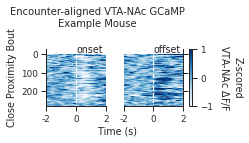

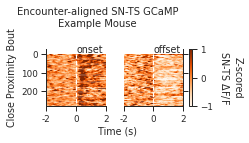

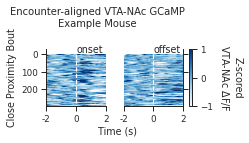

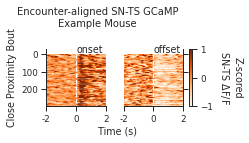

close proximity VTA-NAc 310 318
345
336
329
377
392
29
182
10 8
onset 1 -0.3164308557264177 0.7557663639885513
10 7
onset 2 2.2172276254028946 0.04247422752420082
11 8
onset 3 1.13812284130056 0.2708553990138431
11 8
onset 4 2.112352174572664 0.049754649332134936
11 8
onset 5 1.4607299058332863 0.16232556450646254
11 8
onset 6 0.7447319799909112 0.4666051867113957
10 7
onset 7 0.4808523918236625 0.6375597825372737
10 8
onset 8 0.7442773776379535 0.4674998340825328
11 7
onset 9 2.1384880870230716 0.048248644302905624
10 8
onset 10 0.33008121915050886 0.7456209626066219
onset [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  182
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                   8
                     

<Figure size 720x720 with 0 Axes>

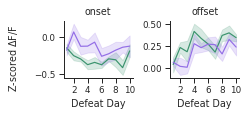

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  182
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                   8
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.6
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           0.099
Covariance type:                    robust   Time:                         21:22:01
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4034      0.098     -4.122      0.000      -0.595      -0.212
si     

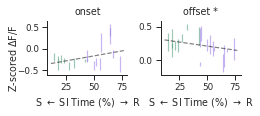

close proximity SN-TS 282 315
345
336
329
377
392
29
182
10 8
onset 1 -0.1980475976211965 0.8455022108152996
10 7
onset 2 -0.9493443526556772 0.3574913937514137
11 8
onset 3 -0.37238566043086535 0.7142074200409106
11 8
onset 4 -0.2250168601438412 0.8246487414942114
11 8
onset 5 -1.648801981115438 0.11754347671125248
11 8
onset 6 -0.9149891853837496 0.37299393002185677
10 7
onset 7 -1.07892261642711 0.29766672041457776
10 8
onset 8 0.3061942774827757 0.763405053323333
11 7
onset 9 -0.41322856434035293 0.6849242976974714
10 8
onset 10 0.8323663501680608 0.41745348776905444
onset [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  182
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                   8
                  

<Figure size 720x720 with 0 Axes>

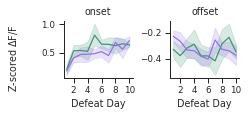

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  182
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                   8
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                 9.6
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           0.144
Covariance type:                    robust   Time:                         21:22:03
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4824      0.119      4.071      0.000       0.250       0.715
si     

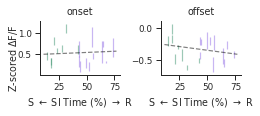

In [38]:
BAD_NAC = {13,335,353,59,30,313,71}

FS=120
for behavior in ['close proximity']:
    preattack2nac={}
    postattack2nac={}
    preattack2ts={}
    postattack2ts={}
    preXs={}
    postXs={}
    span=2*FS
    sns.set_style("ticks")

    for m in r2s:
        if m ==30 or m in BAD_NAC:
            continue
        ims={('VTA-NAc','onset'):[],
             ('SN-TS','onset'):[],
             ('VTA-NAc','offset'):[],
             ('SN-TS','offset'):[]}
        for d in range(1,11):
            k=(m,d)
            if m in BAD_NAC:
                continue
            if k in BAD_SESSIONS:
                continue
            if k not in rf_scores or 'fpnac_samp' not in alldat[k]:
                continue
                
            attack=(alldat[k]['body_part_tracking']['TopBetweenCentroidDistance']<120).astype(int)#SHOULD BE 120

            if not np.sum(attack):
                continue
            starts = np.where(attack[1:]-attack[:-1]==1)[0]
            sparse_starts= [a for i,a in enumerate(starts) if np.sum(attack[a-FS:a])==0]

            ends = np.where(attack[:-1]-attack[1:]==1)[0]
            sparse_ends= [a for i,a in enumerate(ends) if np.sum(attack[a+1:a+FS])==0]

            before=np.array([(np.arange(start-span,start+span)/FS*FP_FS).astype(int) for start in sparse_starts if (start+span)/FS*FP_FS<len(alldat[k]['fpnac_samp'])])
            after=np.array([(np.arange(end-span,end+span)/FS*FP_FS).astype(int) for end in sparse_ends if end-span>0 and (end+span)/FS*FP_FS<len(alldat[k]['fpnac_samp'])])

            if not len(before) or not len(after):
                continue
            preattack2nac[k]=[alldat[k]['fpnac_samp'][b]-alldat[k]['fpnac_samp'][b][:span].mean() for b in before]
            postattack2nac[k]=[alldat[k]['fpnac_samp'][a]-alldat[k]['fpnac_samp'][a][:span].mean() for a in after]
            preattack2ts[k]=[alldat[k]['fpts_samp'][b]-alldat[k]['fpts_samp'][b][:span].mean() for b in before]
            postattack2ts[k]=[alldat[k]['fpts_samp'][a]-alldat[k]['fpts_samp'][a][:span].mean() for a in after]

            preX=np.zeros((before.shape[0],before.shape[1]))
            postX=np.zeros((before.shape[0],before.shape[1]))
            
            ims[('VTA-NAc','onset')].append(preattack2nac[k])
            ims[('VTA-NAc','offset')].append(postattack2nac[k])
            ims[('SN-TS','onset')].append(preattack2ts[k])
            ims[('SN-TS','offset')].append(postattack2ts[k])
            
        if len(ims[('SN-TS','offset')])==0:
            continue
            
        toplot={60:'Resilient',
               42:'Susceptible'}
        
        cols={'VTA-NAc':"Blues",
             'SN-TS':'Oranges'}
        
        if m in toplot:
            for reg  in ['VTA-NAc','SN-TS']:
                fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(2.8,1.8))
                for onoff in ['onset','offset']:
                    side=int(onoff=='offset')
                    sns.set_context("paper")
                    sns.set_style('white')

                    im=np.row_stack(ims[(reg,onoff)])
                    im2=axs[side].imshow(im,aspect='auto',cmap=cols[reg],vmin=-1,vmax=1)
                    for a in np.cumsum([len(a) for a in ims[(reg,onoff)]]):
                        axs[side].axhline(y=a,color='white',linewidth=0.33)
                    axs[side].set_xticks([0,240,479])
                    axs[side].set_xticklabels([-2,0,2])
                    axs[side].set_yticks([tick for tick in axs[side].get_yticks() if tick>=0])

                    axs[side].set_ylim(len(im),-int(len(im))/10)
                    sns.despine()
                    axs[side].plot((240,240),(0,len(im)),linestyle='--',color='white')
                    axs[side].text(240,-10,'%s'%(onoff))
                    axs[side].set_xlabel('')
                    axs[side].set_ylabel('Close Proximity Bout')
                    if side:
                        axs[1].yaxis.set_label_position("right")
                        axs[1].yaxis.tick_right()
                        axs[1].spines['left'].set_visible(False)
                        axs[1].spines['right'].set_visible(True)
                        axs[1].set_ylabel('')
                        axs[1].set_yticklabels([])
                    axs[1].yaxis.tick_right()
                    axs[0].yaxis.tick_left()
                    axs[0].xaxis.tick_bottom()
                    axs[1].xaxis.tick_bottom()

                from mpl_toolkits.axes_grid1.inset_locator import inset_axes
                cbar_ax = inset_axes(axs[1],
                           width="5%",  # width = 5% of parent_bbox width
                           height="100%",  # height : 50%
                           loc='lower left',
                           bbox_to_anchor=(1.1, 0., 1, 1),
                           bbox_transform=axs[1].transAxes,
                           borderpad=0,
                           )
                cbar=fig.colorbar(im2, cax=cbar_ax,ticks=[-1, 0, 1, 2])
                cbar.set_label('Z-scored\n%s $\Delta$F/F'%reg,rotation=-90,va='bottom')
                fig.text(0.6, 0.0, 'Time (s)', ha='center')
                plt.tight_layout(pad=1,h_pad=2)
                plt.suptitle("Encounter-aligned %s GCaMP\nExample Mouse"%reg,size=10,
                            verticalalignment='top')

                plt.show()


    s=plot_neural(behavior,preattack2nac,postattack2nac,preattack2ts,postattack2ts,lims=(-1,1,-1.5,2),
               save=False)

    prox_summary=s

In [39]:
from itertools import permutations
nrows=np.arange(len(xe)).astype(int)
xy2nac={(i,j):[] for i,j in permutations(nrows,2)}
xy2ts={(i,j):[] for i,j in permutations(nrows,2)}

mean_nac={}
mean_ts={}

def heatmapdiff(data,data2, axlims=None, bins=100, normed=True, sigma=0.0,subtract=0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    heatmap2, xedges, yedges = np.histogram2d(data2[:,0], data2[:, 1],
            bins=bins, range=axlims, normed=normed)
    
    # Convolve with Gaussian
    heatmap = gaussian_filter((heatmap+0.000001)/(heatmap2+0.000001)-subtract, sigma=sigma)
    return heatmap,xedges,yedges

def heatmapmean(data,z, xe,ye, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=(xe,ye))
    xbins=np.digitize(data[:,0],xe)
    ybins=np.digitize(data[:,1],ye)
    df=pd.DataFrame({'x':xbins,'y':ybins,'n':z})

    df=df.groupby(['x','y']).mean()
    df=df.add_suffix('').reset_index()
    
    meanmap=np.zeros([50,50])
    for x,y,n in df.values:
        if x>=50 or y>=50:
            continue
        meanmap[int(x),int(y)]=n
    return gaussian_filter(meanmap,sigma=sigma)

def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

for i in range(len(xe)):
    xy2nac[(i,i)]=[]
    xy2ts[(i,i)]=[]
for k in alldat.keys():
    if 'fpnac_samp' in alldat[k] and k[0] not in BAD_NAC and k not in BAD_SESSIONS:
        nac=alldat[k]['fpnac_samp']
        ts=alldat[k]['fpts_samp']
        b=alldat[k]['body_part_tracking']['TopBetweenCentroidDistance']
        indices_fp=np.array([int(i*FP_FS/DLC_FS_D) for i in range(len(b)) if i*FP_FS/DLC_FS_D < len(nac)])

        indices_behavior=np.arange(len(indices_fp))
        
        sigma=1.5
        mean_nac[k]=heatmapmean(embeddings2[k][indices_behavior],nac[indices_fp],xe=xe,ye=ye,sigma=sigma)
        mean_ts[k]=heatmapmean(embeddings2[k][indices_behavior],ts[indices_fp],xe=xe,ye=ye,sigma=sigma)

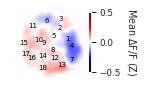

In [56]:
fp_maps=[]
for m in r2s:
    for d in range(1,11):
        if (m,d) in mean_nac:
            fp_maps.append(mean_nac[(m,d)])


plt.figure(figsize=(2,1.8))
sns.set_style('dark')
image=np.mean(fp_maps,axis=0).T
image[np.abs(image-image[0][0])<0.01]=0
im=plt.imshow(image,origin='lower',cmap='seismic',
              vmin=-0.5,vmax=0.5)
cbar=plt.colorbar(im,fraction=0.04,orientation='vertical',pad=0.02)
cbar.ax.set_ylabel('Mean $\Delta$F/F (Z)',rotation=-90,va='bottom')

cbar.set_ticks([-0.5,0,0.5])
for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    xlist.append(x)
    ylist.append(y)
    plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,size=7,
            verticalalignment='center',
            horizontalalignment='center',
            color='k')
plt.vlines(x=1,ymin=2,ymax=12,color='w')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10,color='w')
plt.hlines(y=2,xmin=1,xmax=12,color='w')
plt.text(0.5,-6,'t-SNE 1',size=10,color='w')
plt.axis('off')
plt.show()

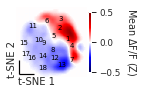

In [57]:
fp_maps=[]
for m in r2s:
    for d in range(1,11):
        if (m,d) in mean_ts:
            fp_maps.append(mean_ts[(m,d)])


plt.figure(figsize=(2,1.8))
sns.set_context("paper")
sns.set_style('dark')
image=np.mean(fp_maps,axis=0).T
image[np.abs(image-image[0][0])<0.01]=0
im=plt.imshow(image,origin='lower',cmap='seismic',
              vmin=-0.5,vmax=0.5)

cbar=plt.colorbar(im,fraction=0.04,orientation='vertical',pad=0.02,label='Log Odds of Peak')
cbar.ax.set_ylabel('Mean $\Delta$F/F (Z)',rotation=-90,va='bottom')
cbar.set_ticks([-0.5,0,0.5])

for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    xlist.append(x)
    ylist.append(y)
    plt.text(x,y,np.where(np.argsort(tsne_dists)==int(i)-1)[0][0]+1,size=7,
            verticalalignment='center',
            horizontalalignment='center',
            color='k')
plt.vlines(x=1,ymin=2,ymax=12,color='k')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
plt.hlines(y=2,xmin=1,xmax=12,color='k')
plt.text(0.5,-6,'t-SNE 1',size=10)
plt.axis('off')

sns.set_style('ticks')

In [70]:
tsVdists={'d':[],'t':[]}
nacVdists={'d':[],'n':[]}
stsVdists={'d':[],'t':[]}
snacVdists={'d':[],'n':[],'day':[]}
rtsVdists={'d':[],'t':[]}
rnacVdists={'d':[],'n':[]}
sregr={'day':[],'r':[]}
rregr={'day':[],'r':[]}
for r2si,m in enumerate(r2s):
    mn=[]
    md=[]
    mt=[]
    for day in range(1,11):
        if (m,day) not in alldat:
            continue
        d= alldat[(m,day)]
        if 'body_part_tracking' not in d:
            continue
        dists=np.round(d['body_part_tracking']['TopBetweenCentroidDistance']/11.5,0)
        if 'fpts_samp' not in d or not len(d['fpts_samp']):
            continue
        indices=[int(i*FP_FS/FS) for i in range(len(dists)) if i*FP_FS/FS<len(d['fpnac_samp'])]
        i_d=[i for i in range(len(dists)) if i*FP_FS/FS<len(d['fpnac_samp'])]
        mt.append(d['fpts_samp'][indices][::12])
        md.append(dists[i_d][::12])
        mn.append(d['fpnac_samp'][indices][::12])
    if len(md)==0:
        continue
    dftemp=pd.DataFrame({'d':np.concatenate(md),
                        'n':np.concatenate(mn),
                        't':np.concatenate(mt)})
    
    for d,g in dftemp.groupby('d'):
        k=(m,10)
        n=g.n.mean()
        t=g.t.mean()
        if k[0] not in BAD_TS:
            tsVdists['t'].append(t)
            tsVdists['d'].append(d)
            if k[0] in r2s[RFCUTOFF:]:
                rtsVdists['t'].append(t)
                rtsVdists['d'].append(d)  
            else:
                stsVdists['t'].append(t)
                stsVdists['d'].append(d)
        if  k[0] not in BAD_NAC and k not in BAD_SESSIONS:
            nacVdists['n'].append(n)
            nacVdists['d'].append(d)
            if k[0] in r2s[RFCUTOFF:]:
                rnacVdists['n'].append(n)
                rnacVdists['d'].append(d)
            else:
                snacVdists['n'].append(n)
                snacVdists['d'].append(d)

            

In [71]:
df = pd.DataFrame({'t':tsVdists['t'],
              'd':tsVdists['d']})
dfn = pd.DataFrame({'n':nacVdists['n'],
              'd':nacVdists['d']})
dfr = pd.DataFrame({'t':rtsVdists['t'],
              'd':rtsVdists['d']})
dfnr = pd.DataFrame({'n':rnacVdists['n'],
              'd':rnacVdists['d']})
dfs = pd.DataFrame({'t':stsVdists['t'],
              'd':stsVdists['d']})
dfns = pd.DataFrame({'n':snacVdists['n'],
              'd':snacVdists['d']})

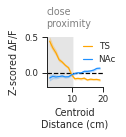

In [87]:
import matplotlib.patches as patches

sns.set_context("paper")
sns.set_style('ticks')
fig,ax=plt.subplots(1,1,figsize=(1.8,2.2))
plt.axhline(y=0,color='k',linestyle='--')
sns.lineplot(data=df.query('d<20 and d>2'),x='d',y='t',label='TS',color='orange',ci=68)
sns.lineplot(data=dfn.query('d<20 and d>2'),x='d',y='n',color='dodgerblue',label='NAc',ci=68)

sns.despine()
plt.ylabel('Z-scored $\Delta$F/F')
plt.xlabel('Centroid\nDistance (cm)')
l = plt.legend(bbox_to_anchor=(0.5,0.3),
            title=None,frameon=0,handlelength=1)

rect = patches.Rectangle((0, -2), 10.5,3, linewidth=1, edgecolor=None, facecolor='grey',
                        zorder=0,alpha=0.2)
plt.text(x=2,y=0.65,s='close\nproximity',color='grey')

ax.add_patch(rect)
plt.ylim(-0.2,0.5)
plt.xlim(2,20)
plt.show()

## Encoding Model

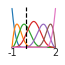

In [88]:
from patsy import dmatrices, dmatrix
'''
11-degrees-of-freedom regression spline basis set with a 2-s duration
'''
fr=FS
spline_w=3
x = np.linspace(0., 3., spline_w*fr)
datax={'x': x}
nsplines=7
splines = dmatrix('bs(x, df=%s, degree=3, include_intercept=True) - 1'%nsplines,{'x': x})
plt.figure(figsize=(1,1))
plt.plot(x-1, splines)
plt.axis('off')
plt.axvline(x=0,linestyle='--',color='k')
plt.text(-1,-0.01,'-1',horizontalalignment='center',verticalalignment='top')
plt.text(2,-0.01,'2',horizontalalignment='center',verticalalignment='top')
plt.tight_layout()
plt.show()

def make_splines(nsplines=17,spline_w=3,fr=FS):
    x = np.linspace(0., spline_w, spline_w*fr)
    splines = dmatrix('bs(x, df=%s, degree=3, include_intercept=True) - 1'%nsplines,{'x': x})
    return (splines)

In [89]:
preattack2nac={}
preattack2ts={}
span=5*120
sns.set_style("ticks")
befores={}
befores2={}
ses={}
for m in r2s:
    if m ==30 or m in BAD_NAC:
        continue

    for d in range(1,11):
        k=(m,d)
        if m in BAD_NAC:# or m FIGHTERS:
            continue
        if k in BAD_SESSIONS:
            continue
        if k not in alldat or 'fpnac_samp' not in alldat[k]:
            continue

            
        attack=(alldat[k]['body_part_tracking']['TopBetweenCentroidDistance']<120).astype(int)

        
        if not np.sum(attack):
            continue
        starts = np.where(attack[1:]-attack[:-1]==1)[0]
        sparse_starts= [a for i,a in enumerate(starts) if np.sum(attack[a-FS:a])==0 and  a+span<len(attack) and a-span>0 and np.sum(attack[a:a+30])>10]

        ends = np.where(attack[:-1]-attack[1:]==1)[0]
        sparse_ends= [a for i,a in enumerate(ends) if np.sum(attack[a+1:a+FS])==0 and a+span<len(attack) and a-span>0 and np.sum(attack[a-30:a])>10]

        
        s_e=[(s,np.array(sparse_ends)[sparse_ends>s][0]) for s in sparse_starts if np.sum(sparse_ends>s)]
        ses[k]=s_e
        
        before=[(np.arange(s-span,e+span)/FS*FP_FS).astype(int) for s,e in s_e if (e+span)/FS*FP_FS<len(alldat[k]['fpnac_samp']) and s-span>0]

        if not len(before) :
            continue
        befores2[k]=[(np.arange(s-span,e+span)).astype(int) for s,e in s_e if (e+span)/FS*FP_FS<len(alldat[k]['fpnac_samp']) and s-span>0]

        e=np.min([len(attack),int(len(alldat[k]['fpnac_samp'])/FP_FS*FS)])

        befores[k]=np.arange(e).astype(int)
        before=[(np.arange(e)/FS*1017).astype(int)]

        preattack2nac[k]=[alldat[k]['fpnac_samp'][b] for b in before]
        preattack2ts[k]=[alldat[k]['fpts_samp'][b] for b in before]

In [90]:
def create_feats_md_full_session(m,d,remove_c=-1,remove_d=-1,nsplines=11,ts=False):
    k=(m,d)
    if ts:
        y=np.concatenate(preattack2ts[k])
    else:
        y=np.concatenate(preattack2nac[k])

    # onsets and offsets for attack, fight, and flee
    X_d=[]
    on_offs=[]

    splines=make_splines(nsplines=nsplines)
    behaves=['fightback','runaway','attack','sniffing']
    if remove_d>=0:
        behaves=behaves[:remove_d]+behaves[remove_d+1:]
    for behavior in behaves:
        attack=rf_scores[k][behavior].astype(int)

        starts = np.where(attack[1:]-attack[:-1]==1)[0]
        sparse_starts= [a for i,a in enumerate(starts) if np.sum(attack[a-FS:a])==0 and  a+span<len(attack) and a-span>0]

        ends = np.where(attack[:-1]-attack[1:]==1)[0]
        sparse_ends= [a for i,a in enumerate(ends) if np.sum(attack[a+1:a+FS])==0 and a+span<len(attack) and a-span>0]

        start_array=np.zeros((len(attack),len(splines.T)))
        start_array[sparse_starts,:]=1
        end_array=np.zeros((len(attack),len(splines.T)))
        end_array[sparse_ends,:]=1
        
        for i in range(len(splines.T)):
            start_array[:,i]=np.convolve(start_array[:,i],splines.T[i],'full')[FS-1:-FS*2]
            end_array[:,i]=np.convolve(end_array[:,i],splines.T[i],'full')[FS-1:-FS*2]

        X_d.append([start_array[(b).astype(int)] for b in befores[k]])
        X_d.append([end_array[(b).astype(int)] for b in befores[k]])
        
    x=np.column_stack(X_d)
    return(x,y)

In [91]:
def create_feats_full_session(m,remove_c=-1,remove_d=-1,nsplines=7,ts=False):
    xs=[]
    ys=[]
    for d in range(1,11):
        k=(m,d)
        if k not in preattack2nac:
            continue
        print(m,d,ts,nsplines)
        x,y=create_feats_md_full_session(m,d,ts=ts,nsplines=nsplines)
        xs.append(x)
        ys.append(y)
    return (xs,ys)

In [92]:
import statsmodels.api as sm
def regress(x,y,toprint=True):
    from sklearn import linear_model 
    x2=sm.add_constant(x)
    regr = sm.OLS(y,x2)
    results=regr.fit()
    pred=results.predict(x2)
    if toprint:
        print(np.corrcoef(pred,y)[1,0])
    return(results,np.corrcoef(pred,y)[1,0]**2)

In [93]:
## EXAMPLE
m=42
xs,ys=create_feats_full_session(m)

x=np.row_stack(xs)
y=np.concatenate(ys)

x2=sm.add_constant(x)
regr,_=regress(x,y)

42 1 False 7
42 2 False 7
42 3 False 7
42 4 False 7
42 5 False 7
42 6 False 7
42 7 False 7
42 8 False 7
42 9 False 7
42 10 False 7
0.18565531340066996


In [94]:
bout_lens={m:[len(befores[(m,d)]) for d in range(1,11) if (m,d) in befores] for m in r2s if m not in BAD_NAC}

In [96]:
ysim= regr.predict(x2)

lens=[]
ysimreshape=[]
yreshape=[]
corrs=[]
added=0
ses_forcorrs=[]
dists_forcorrs=[]
bt=240
for d in range(1,11):
    for s,e in ses[(m,d)]:
        if s-bt>0 and s+FS*5<len(ys[d-1]):
            
            y_st=ysim[s-bt+added:s+FS*5+added]
            if np.sum(y_st==y_st[0])==len(y_st):
                continue
            ysimreshape.append((y_st-y_st.mean())/y_st.std())
            ys1=ys[d-1][s-bt:s+FS*5]
            yreshape.append((ys1-ys1.mean())/ys1.std())
            dists_forcorrs.append(alldat[(m,d)]['body_part_tracking']['TopBetweenCentroidDistance'][s-bt:s+FS*5])
            c=np.corrcoef(ys[d-1][s-bt:s+FS*5],y_st)[0][1]
            corrs.append(c)
            ses_forcorrs.append((s-bt+added,s+FS*5+added))
            lens.append(e-s)
            if np.isnan(c):
                print (d,ysim[s-bt+added:s+FS*5+added])
    added+=len(ys[d-1])
bls=lens

In [97]:
lens_b=[]
ysimreshape_b=[]
yreshape_b=[]
corrs_b=[]
added=0

bt=240
for d in range(1,11):
    for s,e in ses[(m,d)]:
        if e-bt>0 and e+bt<len(ys[d-1]):
            
            y_st=ysim[e-bt+added:e+bt+added]
            if len(y_st)==0 or np.sum(y_st==y_st[0])==len(y_st):
                continue
            ysimreshape_b.append((y_st-y_st.mean())/y_st.std())
            yreshape_b.append((ys[d-1][e-bt:e+bt]-ys[d-1][e-bt:e+bt].mean())/ys[d-1][e-bt:e+bt].std())
            lens_b.append(e-s)
    added+=len(ys[d-1])
bls=lens

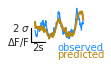

In [98]:
i=np.argsort(corrs)[-5]
t=np.arange(0,lens[i]+240)
ax=plt.figure(figsize=(2.,1.3))
plt.plot(np.arange(len(yreshape[i])),yreshape[i],label='true',color='dodgerblue')
plt.plot(np.arange(len(yreshape[i])),ysimreshape[i],label='predicted',color='darkgoldenrod',
        linewidth=2)
plt.xlim()

plt.text(FS*10,-2.8,'observed',horizontalalignment='right',
            verticalalignment='center',color='dodgerblue',
            size=10)
plt.text(FS*10,-3.9,'predicted',horizontalalignment='right',
            verticalalignment='center',color='darkgoldenrod',
            size=10)

plt.axis('off')
plt.plot([-60,180],[-2,-2],color='k')
plt.text(60,-2.8,'2s',horizontalalignment='center',
            verticalalignment='center',
            size=10)
plt.plot([-60,-60],[-2,0],color='k')
plt.text(-80,-1,'2 $\sigma$\n$\Delta$F/F',horizontalalignment='right',
            verticalalignment='center',
            size=10)

plt.show()

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


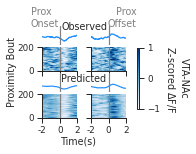

In [99]:
fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(1.5,1.7),sharex=True,sharey='row',
                    gridspec_kw={'height_ratios':[1,1.2,1,1.2],'hspace': 0.1,'wspace':0.4})
axs[3][1].imshow(np.array(ysimreshape_b),aspect='auto',vmin=-1.5,vmax=2,cmap='Blues')
im=axs[1][1].imshow(np.array(yreshape_b),aspect='auto',vmin=-1,vmax=1,cmap='Blues')
axs[3][0].imshow(np.array(ysimreshape)[:,:FS*4],aspect='auto',vmin=-1.5,vmax=2,cmap='Blues')
im=axs[1][0].imshow(np.array(yreshape)[:,:FS*4],aspect='auto',vmin=-1,vmax=1,cmap='Blues')
axs[2][0].plot(np.mean(np.array(ysimreshape)[:,:FS*4],axis=0),color='dodgerblue')
axs[0][0].plot(np.mean(np.array(yreshape)[:,:FS*4],axis=0),color='dodgerblue')
axs[2][1].plot(np.mean(np.array(ysimreshape_b)[:,:FS*4],axis=0),color='dodgerblue')
axs[0][1].plot(np.mean(np.array(yreshape_b)[:,:FS*4],axis=0),color='dodgerblue')
for a in axs[[1,3]]:
    for ax in a:
        ax.set_ylim(0,200)
        sns.despine()
        ax.axvline(x=240,color='grey')
        ax.set_xticks([0,240,480])
        ax.set_xticklabels([-2,0,2])
for a in axs[[0,2]]:
    for ax in a:
        ax.axis('off')
        ax.axvline(x=240,color='grey')
axs[2][0].set_ylim(-2,5)
axs[0][0].set_ylim(-1,1.5)

fig.text(-0.2, 0.5, 'Proximity Bout', va='center', rotation='vertical')
fig.text(0.3, -0.07, 'Time(s)', va='center', )
fig.text(0.3, 0.44, 'Predicted', va='center', )
fig.text(0.3, 0.87, 'Observed', va='center', )
fig.text(0.02, 0.87, 'Prox\nOnset', color='grey')
fig.text(1, 0.87, 'Prox\nOffset', ha='right', color='grey')
position=fig.add_axes([1,0.2,0.02,0.5])
cbar=fig.colorbar(im,ax=axs,fraction=0.018,cax=position)

cbar.set_label('VTA-NAc\n Z-scored $\Delta$F/F',rotation=-90, va="bottom")
plt.subplots_adjust(hspace=0.0001)

plt.show()

In [100]:
titles=['fightback start','fightback end',
 'runaway start','runaway end',
 'attack start','attack end',
 'sniffing start','sniffing end']
kernels1={}
models1={}
xs1={}
ys1={}
for m in r2s:
    print(m)
    xs,ys=create_feats_full_session(m,nsplines=nsplines)
    if len(xs)==0:
        continue
    x=sm.add_constant(np.row_stack(xs))
    y=np.concatenate(ys)
    regr,_=regress(x,y)
    models1[m]=regr
    kernels1[m]={}
    xs1[m]=x
    ys1[m]=ys
    for i in range(len(titles)):
        kern=np.sum(splines*regr.params[i*len(splines.T)+1:(i+1)*len(splines.T)+1],axis=1)
        kernels1[m][titles[i]]=kern

30
375
375 1 False 7
375 2 False 7
375 3 False 7
375 4 False 7
375 5 False 7
375 6 False 7
375 8 False 7
375 9 False 7
375 10 False 7
0.12452414761784751
362
362 1 False 7
362 2 False 7
362 3 False 7
362 4 False 7
362 5 False 7
362 6 False 7
362 7 False 7
362 8 False 7
362 9 False 7
362 10 False 7
0.18370065141313266
40
40 1 False 7
40 2 False 7
40 3 False 7
40 4 False 7
40 5 False 7
40 6 False 7
40 7 False 7
40 8 False 7
40 9 False 7
40 10 False 7
0.21057346191141446
345
11
11 1 False 7
11 2 False 7
11 3 False 7
11 4 False 7
11 5 False 7
11 6 False 7
11 7 False 7
11 8 False 7
11 9 False 7
11 10 False 7
0.1303378088292382
41
41 1 False 7
41 2 False 7
41 3 False 7
41 4 False 7
41 5 False 7
41 6 False 7
41 7 False 7
41 8 False 7
41 9 False 7
41 10 False 7
0.15118444447578733
13
335
42
42 1 False 7
42 2 False 7
42 3 False 7
42 4 False 7
42 5 False 7
42 6 False 7
42 7 False 7
42 8 False 7
42 9 False 7
42 10 False 7
0.18565531340066996
346
346 1 False 7
346 3 False 7
346 4 False 7
346 5 Fal

190
12 7
fight-back start 1 1.7773638440903272 0.09340244453649804
12 7
fight-back start 2 1.7773638440903272 0.09340244453649804
12 7
fight-back start 3 1.7773638440903272 0.09340244453649804
12 7
fight-back start 4 1.7773638440903272 0.09340244453649804
12 7
fight-back start 5 1.7773638440903272 0.09340244453649804
12 7
fight-back start 6 1.7773638440903272 0.09340244453649804
12 7
fight-back start 7 1.7773638440903272 0.09340244453649804
12 7
fight-back start 8 1.7773638440903272 0.09340244453649804
12 7
fight-back start 9 1.7773638440903272 0.09340244453649804
12 7
fight-back start 10 1.7773638440903272 0.09340244453649804
fight-back start [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  190
Model:                                 GEE   No. clusters:                       19
Method:                        Gen

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


12 7
fight-back end 2 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 3 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 4 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 5 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 6 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 7 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 8 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 9 -1.6349878740886026 0.12043122440932126
12 7
fight-back end 10 -1.6349878740886026 0.12043122440932126
fight-back end [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  190
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                  10
                      Estima

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


12 7
attacked start 10 1.614800877140585 0.12475986022366946
attacked start [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  190
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                           0.012
Covariance type:                    robust   Time:                         12:56:46
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


12 7
investigated start 7 0.8280074597309525 0.41913913657601176
12 7
investigated start 8 0.8280074597309525 0.41913913657601176
12 7
investigated start 9 0.8280074597309525 0.41913913657601176
12 7
investigated start 10 0.8280074597309525 0.41913913657601176
investigated start [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  190
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 28 Jun 2022   Scale:                   

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1781: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


<Figure size 720x720 with 0 Axes>

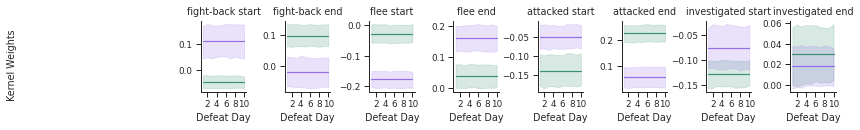

(0.46785295608289224, 0.04338146375698788)
(-0.43233703094452763, 0.06450771046103662)
(-0.8016943286253879, 3.672781684651236e-05)
(0.5800540091013568, 0.009229406590462057)
(0.5121934047226653, 0.024959645293582744)
(-0.6032903603052424, 0.006245603521551922)
(0.2803872504396964, 0.2449445933971226)
(-0.08149118995563147, 0.7401542694992326)


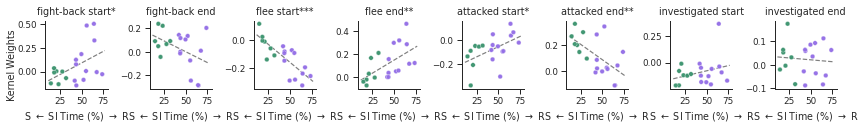

In [101]:
titles2=['fight-back start','fight-back end',
 'flee start','flee end',
 'being attacked start','being attacked end',
 'being sniffed start','being sniffed end']

gain_dict={'c':[],'d':[],'m':[],'t':[],'r2s':[],'rb':[],'si':[]}
for i,m in enumerate(r2s):
    if m not in bout_lens or m in BAD_NAC:
        continue
    d_i=0
    for d in range(1,11):
        if (m,d) not in BAD_SESSIONS and (m,d) in alldat and len(bout_lens[m]):
            for b_i,b in enumerate(titles):
                gain_dict['c'].append(titles2[b_i].replace('sniffed','investigated').replace('being ',''))
                gain_dict['d'].append(d)
                gain_dict['m'].append(m)
                gain_dict['t'].append(float(np.mean((kernels1[m][b][90:240]))))
                gain_dict['r2s'].append(i)
                gain_dict['rb'].append(i>=RFCUTOFF)
                gain_dict['si'].append(SI_values[i])
            d_i+=1
            
gain_df=pd.merge(pd.DataFrame(gain_dict),metadat,left_on='m',right_on='Mouse')   
gain_df['sex']='male'

gain_summary=make_behavior_plots(gain_df,aspect=1.3,height=1.9,
                                 order=[t.replace('sniffed','investigated').replace('being ','') for t in titles2],
                   ylabel='Kernel Weights',single_test=True)

used_ms=gain_summary.query('c=="attacked start"').m.values

7
1
2
3
4
5
6
7
8
9
10
11
12
-1.7773638440903272 0.09340244453649804
Ttest_1sampResult(statistic=-1.703249792214493, pvalue=0.13941273773481677)
Ttest_1sampResult(statistic=1.7422512992183736, pvalue=0.10931513014811241)
7
1
2
3
4
5
6
7
8
9
10
11
12
1.6349878740886026 0.12043122440932126
Ttest_1sampResult(statistic=2.671116566539666, pvalue=0.03697147182169184)
Ttest_1sampResult(statistic=-0.35924947601185747, pvalue=0.7262095105708535)


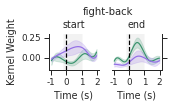

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0.4678529560828922 0.04338146375698798
-0.4323370309445276 0.06450771046103662


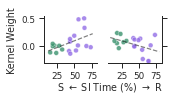

7
1
2
3
4
5
6
7
8
9
10
11
12
3.3294666279641336 0.003969286306158514
Ttest_1sampResult(statistic=-0.8373780928603733, pvalue=0.4344601492395574)
Ttest_1sampResult(statistic=-6.171672221207143, pvalue=6.989856254146128e-05)
7
1
2
3
4
5
6
7
8
9
10
11
12
-1.8658466957411766 0.07941414704314892
Ttest_1sampResult(statistic=0.9109598223324806, pvalue=0.39743681020483224)
Ttest_1sampResult(statistic=3.666452421244634, pvalue=0.0037125395655829415)


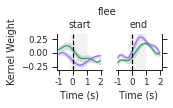

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


-0.8016943286253879 3.672781684651236e-05
0.5800540091013568 0.009229406590462057


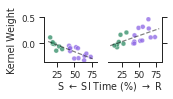

7
1
2
3
4
5
6
7
8
9
10
11
12
-1.614800877140585 0.12475986022366946
Ttest_1sampResult(statistic=-3.0875004068896246, pvalue=0.021456271400111394)
Ttest_1sampResult(statistic=-1.5247464727542175, pvalue=0.1555442980164289)
7
1
2
3
4
5
6
7
8
9
10
11
12
2.8081295782890088 0.012096601936848554
Ttest_1sampResult(statistic=6.41958356570101, pvalue=0.0006745944417940507)
Ttest_1sampResult(statistic=1.432409904528553, pvalue=0.17982614680195644)


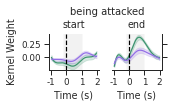

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0.5121934047226654 0.02495964529358272
-0.6032903603052424 0.006245603521551922


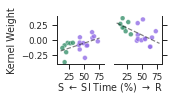

7
1
2
3
4
5
6
7
8
9
10
11
12
-0.8280074597309525 0.41913913657601176
Ttest_1sampResult(statistic=-4.5556100589580435, pvalue=0.0038688202361171196)
Ttest_1sampResult(statistic=-1.6751629329693405, pvalue=0.12206327367137121)
7
1
2
3
4
5
6
7
8
9
10
11
12
0.32609907769458146 0.7483293721518867
Ttest_1sampResult(statistic=0.9805426784688276, pvalue=0.36468581680763945)
Ttest_1sampResult(statistic=0.8875995830451725, pvalue=0.3937498636754052)


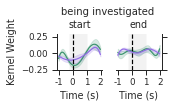

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


0.2803872504396964 0.2449445933971226
-0.08149118995563148 0.7401542694992326


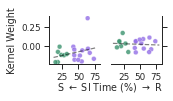

In [102]:
stars=[('*','N.S.'),
      ('***','*'),
      ('*','*'),
      ('N.S.','N.S.')] # based on correlation

lims=[(-0.15,0.3),
      (-0.3,0.35),
      (-0.24,0.46),
      (-0.25,0.3)]

dat_list = {'mean':[],
            'time':[],
            'sem':[],
            'rb':[],
            'behavior':[],
            'onoff':[]}

for k in range(int(len(titles)/2)):
    pi=0
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(2.5,1.7),sharey=True,sharex=True)
    for onoff in range(2):
        t_i=k*2+pi
        title=titles[t_i]

        ax=axs[int(pi)]
        kplt=[]
        for m,ks in kernels1.items():
            if m in r2s[RFCUTOFF:] or m in BAD_NAC:
                continue
            kplt.append(ks[title])
        print(len(kplt))
        mk=np.mean(kplt,axis=0)
        sk=scipy.stats.sem(kplt,axis=0)
        
        dat_list['mean']+=list(mk)
        dat_list['sem']+=list(sk)
        dat_list['rb']+=['susceptible']*len(sk)
        dat_list['time']+=list(np.arange(len(sk))/FS-1)
        dat_list['behavior']+=[k]*len(sk)
        dat_list['onoff']+=[onoff]*len(sk)
        
            
        ax.plot(mk,color=ggp[1])
        ax.fill_between(np.arange(len(splines)),mk-sk,mk+sk,alpha=0.2,label='susceptible (n=%d)'%len(kplt),
                         color=ggp[1])
        
        kpltr=np.array(kplt)
        kplt=[]
        for m,ks in kernels1.items():
            if m in r2s[:RFCUTOFF]:
                continue
            kplt.append(ks[title])

            print(len(kplt))
        mk=np.mean(kplt,axis=0)
        sk=scipy.stats.sem(kplt,axis=0)
        
        dat_list['mean']+=list(mk)
        dat_list['sem']+=list(sk)
        dat_list['rb']+=['resilient']*len(sk)
        dat_list['time']+=list(np.arange(len(sk))/FS-1)
        dat_list['behavior']+=[k]*len(sk)
        dat_list['onoff']+=[onoff]*len(sk)
        
        ax.plot(mk,color=ggp[2])
        ax.fill_between(np.arange(len(splines)),mk-sk,mk+sk,alpha=0.2,
                         label='resilient (n=%d)'%len(kplt),color=ggp[2])


        ax.axvline(x=FS,color='k',linestyle='--')
        ax.set_xticks(np.arange(3.1)*FS)
        ax.set_xticklabels(np.arange(3.001).astype(int)-1)
        ax.set_title(titles2[t_i].split(' ')[-1])
        ax.set_xlabel('Time (s)')
        if 'end' in title:
            sns.despine(ax=ax)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(True)
            ax.yaxis.tick_right()
        else:
            sns.despine(ax=ax)
        kplts=np.array(kplt)


        t,p=scipy.stats.ttest_ind(kpltr[:,90:240].mean(axis=1),
                                    kplts[:,90:240].mean(axis=1))
        
        print(t,p)
        print(scipy.stats.ttest_1samp(kpltr[:,90:240].mean(axis=1),0))
        print(scipy.stats.ttest_1samp(kplts[:,90:240].mean(axis=1),0))

        lim=ax.get_ylim()
        ax.set_title('%s'%(ax.get_title()),horizontalalignment='center')
        rect = patches.Rectangle((90, -0.5), 240-90, 1, linewidth=1, edgecolor=None, facecolor='grey',
                                zorder=0,alpha=0.1)

        ax.add_patch(rect)
        ax.set_ylim(lims[k])
        pi+=1

    mid = (fig.subplotpars.right + fig.subplotpars.left)/5*3
    plt.suptitle(titles2[t_i].replace(' start','').replace(' end',''),size=10,y=0.85,x=mid,
                 ha='center')
    if 'sniff' in titles2[t_i]:
        plt.suptitle('being investigated',size=10,y=0.85,x=mid,ha='center')
    axs[0].set_ylabel('Kernel Weight')
    plt.tight_layout()

    plt.show()
    
    
    title_test=titles2[t_i]
    if 'sniff' in titles2[t_i]:
        title_test='investigated end'
    title_test=title_test.replace("being ",'')
    title_test0=title_test.replace('end','start')
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(2.5,1.2),sharey=True,sharex=True)
    for i,tt in enumerate([title_test0,title_test]):
        test=gain_summary.query('c=="%s"'%tt)[['m','t','rb','si']].drop_duplicates()
        sns.scatterplot(data=test,x='si',y='t',ax=axs[i],hue='rb',legend=False,palette=ggp[[1,2]],alpha=0.8)


        r,p=scipy.stats.pearsonr(test.si,test.t)
        lr = LinearRegression()
        lr.fit(test.si.values.reshape(-1, 1),test.t.values,)
        print(r,p)
        abline(lr.coef_, lr.intercept_,axs[i])

    sns.despine(ax=ax)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(True)
    axs[1].spines['top'].set_visible(False)
    axs[1].yaxis.tick_right()
    axs[0].set_ylabel('Kernel Weight')
    for ax in axs: ax.set_xlabel('')

    sns.despine(ax=axs[0])
    plt.tight_layout()
    fig.text(0.63,0.02,r'S $\leftarrow$ SI Time (%) $\rightarrow$ R',ha='center')
    plt.show()

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore

(0.5722945863671272, 0.010450309050308111)
(-0.3252867663249789, 0.1741672969839119)
0.1741672969839119
(0.28129773196942454, 0.2433507312049681)
0.2433507312049681
(-0.3572199858484242, 0.13324437357178365)
0.13324437357178365
(-0.0528639486508814, 0.8298183021833495)
0.8298183021833495
(0.1608448685538119, 0.5106580868707036)
0.5106580868707036


/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


(-0.3220321875474361, 0.1787681736005806)
0.1787681736005806
(0.4418015012867801, 0.05824971874189521)
0.05824971874189521


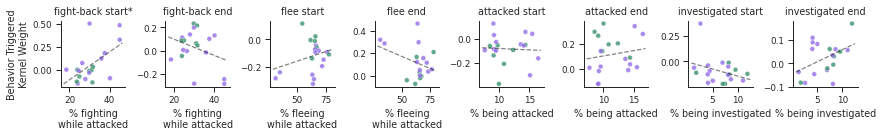

In [103]:
labs=[("fight-back start","fighting while attacked"),
     ("fight-back end","fighting while attacked"),
     ("flee start","fleeing while attacked"),
     ("flee end","fleeing while attacked"),
      ("attacked start","being attacked"),
     ("attacked end","being attacked"),
      ("investigated start","being investigated"),
     ("investigated end","being investigated")]
fig,axs=plt.subplots(nrows=1,ncols=int(len(labs)),figsize=(12.1,2),sharey=False,sharex=False)
for i,l in enumerate(labs):
    test=pd.merge(gain_summary.query('c=="%s"'%l[0])[['m','t','rb']].drop_duplicates(),
             rf_summary.query('c=="%s"'%l[1])[['m','t']],
             on='m')

    sns.scatterplot(data=test,x='t_y',y='t_x',ax=axs[i],hue='rb',legend=False,palette=ggp[[1,2]],alpha=0.8)
    print(scipy.stats.pearsonr(test.t_x,test.t_y))
    
    p=scipy.stats.pearsonr(test.t_x,test.t_y)[1]
    
    r,p=scipy.stats.pearsonr(test.t_x,test.t_y)
    lr = LinearRegression()
    lr.fit(test.t_y.values.reshape(-1, 1),test.t_x.values,)
    
    abline(lr.coef_, lr.intercept_,axs[i])
    if p<0.05:
        axs[i].set_title(l[0].replace('sniffed','investigated')+'*')
        axs[i].set_ylabel('Behavior Triggered\nKernel Weight')
    else:
        axs[i].set_title(l[0].replace('sniffed','\ninvestigated'))
        print(p)
        axs[i].set_ylabel('')
    axs[i].set_xlabel('%% %s'%l[1].replace(' while','\nwhile'))
    
sns.despine()
plt.tight_layout()
plt.show()

In [104]:
# compare to histology

targeting=pd.read_csv('fp_targeting.csv')
shell_m=targeting.query('NAc_region=="shell"').m.values
core_m=targeting.query('NAc_region=="core"').m.values
targeting['NAc_ML_abs']=np.abs(targeting['NAc_ML'])
targeting['TS_ML_abs']=np.abs(targeting['TS_ML'])

(0.12866632281072585, 0.41091442636720793)
(-0.10087171759458011, 0.5198260277447615)
(0.03268205825174387, 0.835189181623539)
(-0.10233169370456627, 0.5137704924452094)
(0.07019067143959679, 0.6546869664456759)
(-0.06262725537304037, 0.6899189566746536)


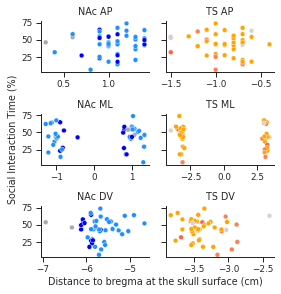

In [105]:
si_targeting=pd.merge(targeting,metadat[['mouse','SI_time']],left_on='m',right_on='mouse')
axes=['AP','ML','DV']
regions=['NAc','TS']
pal=[['dodgerblue','blue','darkgrey'],
     ['orange','tomato','coral','lightgrey']]
fig,axs=plt.subplots(nrows=3,ncols=2,figsize=(4,4),sharey=True)
for i,a in enumerate(axes):
    for j,r in enumerate(regions):
        sns.scatterplot(ax=axs[i][j],data=si_targeting,
                        x='%s_%s'%(r,a),y='SI_time',hue='%s_region'%r,legend=None,
                       palette=pal[j])
        print(scipy.stats.pearsonr(si_targeting['%s_%s'%(r,a)],si_targeting['SI_time']))
        axs[i][j].set_title('%s %s'%(r,a.split('_')[0]))
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
axs[1][0].set_ylabel('Social Interaction Time (%)')
fig.text(0.55, 0, 'Distance to bregma at the skull surface (cm)', ha='center')
sns.despine()
plt.show()

[ 11 340 346  61 312 314  41  60 375  42 364  40 362 332 363 376  70 301
  32]
fightback start kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=0.14, p=0.89, NS
fightback end kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=0.96, p=0.35, NS
runaway start kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=0.15, p=0.88, NS
runaway end kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=-1.27, p=0.22, NS
attack start kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=-2.17, p=0.04, *
attack end kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=1.49, p=0.16, NS
sniffing start kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=-1.39, p=0.18, NS
sniffing end kernel weight at right vs left locations , 19 mice, t-Tests, Difference in mean, t=1.21, p=0.24, NS


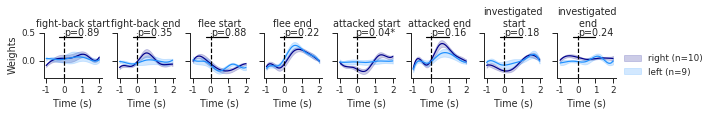

[346 332  41  60  61  40 375  42 314 312 362 376  70  11  32 301 340 363
 364]
fightback start kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=1.38, p=0.18, NS
fightback end kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=-0.62, p=0.54, NS
runaway start kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=-1.32, p=0.20, NS
runaway end kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=0.73, p=0.47, NS
attack start kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=-0.03, p=0.98, NS
attack end kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=-0.31, p=0.76, NS
sniffing start kernel weight at posterior vs anterior locations , 19 mice, t-Tests, Difference in mean, t=1.04, p=0.31, NS
sniffing end kernel weight at posterior vs anterior locations , 19

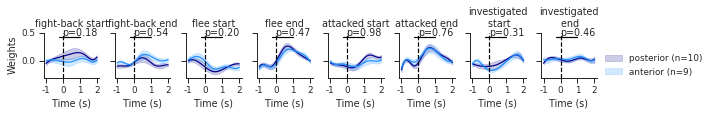

[364 363 346 362 312  60 314  41  42  61  40 376  70 375  11 332  32 340
 301]
fightback start kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=0.41, p=0.69, NS
fightback end kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=-0.32, p=0.76, NS
runaway start kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=0.35, p=0.73, NS
runaway end kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=-0.55, p=0.59, NS
attack start kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=-1.65, p=0.12, NS
attack end kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=0.35, p=0.73, NS
sniffing start kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mean, t=1.30, p=0.21, NS
sniffing end kernel weight at ventral vs dorsal locations , 19 mice, t-Tests, Difference in mea

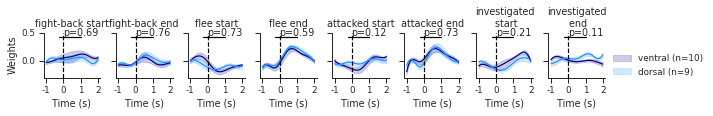

In [106]:
sns.set_style('ticks')
sns.set_context('paper')

titles=['fightback start','fightback end',
 'runaway start','runaway end',
 'attack start','attack end',
 'sniffing start','sniffing end']

splits={'ML':9,
       'AP':9,
       'DV':9}
locs={'ML':['right','left'],
       'AP':['posterior','anterior'],
       'DV':['ventral','dorsal']}
for lab,split in splits.items():
    test_order=targeting.query('m in %s'%list(used_ms)).sort_values('NAc_%s'%lab).m.values
    print(test_order)
    pi=0
    fig,axs=plt.subplots(nrows=1,ncols=len(titles),figsize=(10,1.7),sharey=True)
    for t_i,title in enumerate(titles):

        ax=axs[pi]
        kplt=[]
        for m,ks in kernels1.items():
            if m in test_order[split:] :
                kplt.append(ks[title])

        mk=np.mean(kplt,axis=0)
        sk=scipy.stats.sem(kplt,axis=0)
        axs[pi].plot(mk,color='darkblue')
        axs[pi].fill_between(np.arange(360),mk-sk,mk+sk,alpha=0.2,label=locs[lab][0]+' (n=%d)'%len(kplt),
                         color='darkblue')

        kpltr=np.array(kplt)
        kplt=[]
        for m,ks in kernels1.items():
            if m in test_order[:split]:
                kplt.append(ks[title])

        mk=np.mean(kplt,axis=0)
        sk=scipy.stats.sem(kplt,axis=0)
        axs[pi].plot(mk,color='dodgerblue')
        axs[pi].fill_between(np.arange(360),mk-sk,mk+sk,alpha=0.2,
                         label=locs[lab][1]+' (n=%d)'%len(kplt),color='dodgerblue')


        ax.axvline(x=FS,color='k',linestyle='--')
        ax.set_xticks(np.arange(3.1)*FS)
        ax.set_xticklabels((np.arange(3.1)-1).astype(int))
        ax.set_title(titles2[t_i].replace('sniffed','investigated\n').replace('being ',''))
        ax.set_xlabel('Time (s)')
        axs[0].set_ylabel('Weights')
        sns.despine()
        kplts=np.array(kplt)

        ax.plot([90,240],[0.42,0.42],color='k')

        t,p=scipy.stats.ttest_ind(kpltr[:,90:240].mean(axis=1),
                                    kplts[:,90:240].mean(axis=1))
        star='NS'
        if p <0.01:
            star='**'
            ax.text(240,0.45,'p=%.3f**'%p,horizontalalignment='center')
        elif p <0.05:
            star='*'
            ax.text(240,0.45,'p=%.2f*'%p,horizontalalignment='center')
        else:
            ax.text(240,0.45,'p=%.2f'%p,horizontalalignment='center')
        ax.set_ylim(-0.3,0.5)
        
        filler=', 19 mice, t-Tests, Difference in mean'
        print ('%s kernel weight at %s vs %s locations %s, t=%.2f, p=%.2f, %s'%tuple([title]+locs[lab]+[filler]+[t,p,star]))
        
        pi+=1
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.,0.7),
                title=None,frameon=0)

    plt.show()

fightback start kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=0.52, p=0.61, NS
fightback end kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=-0.07, p=0.94, NS
runaway start kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=-0.28, p=0.78, NS
runaway end kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=0.13, p=0.90, NS
attack start kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=0.44, p=0.66, NS
attack end kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=0.31, p=0.76, NS
sniffing start kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=-0.96, p=0.35, NS
sniffing end kernel weight at core vs shell locations , 19 mice, t-Tests, Difference in mean, t=3.31, p=0.00, **


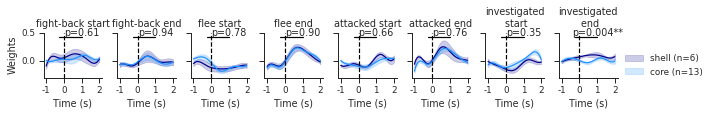

In [107]:
lab='core_shell'
fig,axs=plt.subplots(nrows=1,ncols=len(titles),figsize=(10,1.7),sharey=True)
pi=0
for t_i,title in enumerate(titles):

    ax=axs[pi]
    kplt=[]
    for m,ks in kernels1.items():
        if m in shell_m :
            kplt.append(ks[title])

    mk=np.mean(kplt,axis=0)
    sk=scipy.stats.sem(kplt,axis=0)
    axs[pi].plot(mk,color='darkblue')
    axs[pi].fill_between(np.arange(360),mk-sk,mk+sk,alpha=0.2,label='shell (n=%d)'%len(kplt),
                     color='darkblue')

    kpltr=np.array(kplt)
    kplt=[]
    for m,ks in kernels1.items():
        if m in core_m:
            kplt.append(ks[title])

    mk=np.mean(kplt,axis=0)
    sk=scipy.stats.sem(kplt,axis=0)
    axs[pi].plot(mk,color='dodgerblue')
    axs[pi].fill_between(np.arange(360),mk-sk,mk+sk,alpha=0.2,
                     label='core (n=%d)'%len(kplt),color='dodgerblue')


    ax.axvline(x=FS,color='k',linestyle='--')
    ax.set_xticks(np.arange(3.1)*FS)
    ax.set_xticklabels((np.arange(3.1)-1).astype(int))
    ax.set_title(titles2[t_i].replace('sniffed','investigated\n').replace('being ',''))
    ax.set_xlabel('Time (s)')
    axs[0].set_ylabel('Weights')
    sns.despine()
    kplts=np.array(kplt)

    ax.plot([90,240],[0.42,0.42],color='k')

    t,p=scipy.stats.ttest_ind(kpltr[:,90:240].mean(axis=1),
                                kplts[:,90:240].mean(axis=1))
    star='NS'
    if p <0.01:
        star='**'
        ax.text(240,0.45,'p=%.3f**'%p,horizontalalignment='center')
    elif p <0.05:
        ax.text(240,0.45,'p=%.2f*'%p,horizontalalignment='center')
        star='*'
    else:
        ax.text(240,0.45,'p=%.2f'%p,horizontalalignment='center')
    ax.set_ylim(-0.3,0.5)
    print ('%s kernel weight at core vs shell locations %s, t=%.2f, p=%.2f, %s'%tuple([title]+[filler]+[t,p,star]))
    pi+=1
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.,0.7),
            title=None,frameon=0)
plt.show()

In [108]:
## TS regression
kernels1ts={}
models1ts={}
for m in r2s:
    print(m)
    xs,ys=create_feats_full_session(m,nsplines=nsplines,ts=True)
    if len(xs)==0:
        continue
    x=sm.add_constant(np.row_stack(xs))
    y=np.concatenate(ys)
    regr,_=regress(x,y)
    models1ts[m]=regr
    kernels1ts[m]={}
    for i in range(len(titles)):
        kern=np.sum(splines*regr.params[i*len(splines.T)+1:(i+1)*len(splines.T)+1],axis=1)
        kernels1ts[m][titles[i]]=kern

30
375
375 1 True 7
375 2 True 7
375 3 True 7
375 4 True 7
375 5 True 7
375 6 True 7
375 8 True 7
375 9 True 7
375 10 True 7
0.14334249432088025
362
362 1 True 7
362 2 True 7
362 3 True 7
362 4 True 7
362 5 True 7
362 6 True 7
362 7 True 7
362 8 True 7
362 9 True 7
362 10 True 7
0.11837469526170054
40
40 1 True 7
40 2 True 7
40 3 True 7
40 4 True 7
40 5 True 7
40 6 True 7
40 7 True 7
40 8 True 7
40 9 True 7
40 10 True 7
0.1115646563819627
345
11
11 1 True 7
11 2 True 7
11 3 True 7
11 4 True 7
11 5 True 7
11 6 True 7
11 7 True 7
11 8 True 7
11 9 True 7
11 10 True 7
0.2614670283486543
41
41 1 True 7
41 2 True 7
41 3 True 7
41 4 True 7
41 5 True 7
41 6 True 7
41 7 True 7
41 8 True 7
41 9 True 7
41 10 True 7
0.1193986873990651
13
335
42
42 1 True 7
42 2 True 7
42 3 True 7
42 4 True 7
42 5 True 7
42 6 True 7
42 7 True 7
42 8 True 7
42 9 True 7
42 10 True 7
0.17445426201108824
346
346 1 True 7
346 3 True 7
346 4 True 7
346 5 True 7
346 6 True 7
346 7 True 7
346 8 True 7
346 10 True 7
0.25785

7
12
-0.8613383635803578 0.4010379465329137
7
12
0.23552940181925194 0.8166118136948839
7
12
-0.06343834918317148 0.9501574106712959
7
12
-0.3710531441362242 0.7151814865436397
7
12
0.21526372192547555 0.8321230876620915
7
12
1.8269405542702448 0.08531947560637303
7
12
-0.044336046331396525 0.9651531613949872
7
12
-0.12244976371525416 0.9039787451750816


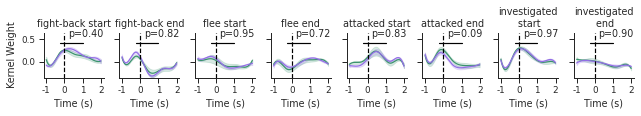

In [109]:
sns.set_style('ticks')
sns.set_context('paper')

titles2=['fight-back start','fight-back end',
 'flee start','flee end',
 'being attacked start','being attacked end',
 'being sniffed start','being sniffed end']

titles=['fightback start','fightback end',
 'runaway start','runaway end',
 'attack start','attack end',
 'sniffing start','sniffing end']


pi=0
fig,axs=plt.subplots(nrows=1,ncols=int(len(titles)),figsize=(9,1.7),sharey=True,sharex=True)
for t_i,title in enumerate(titles):

    ax=axs[int(pi)]
    kplt=[]
    for m,ks in kernels1ts.items():
        if m in r2s[RFCUTOFF:] or m in BAD_NAC:
            continue
        kplt.append(ks[title])

    print(len(kplt))
    mk=np.mean(kplt,axis=0)
    sk=scipy.stats.sem(kplt,axis=0)
    ax.plot(mk,color=ggp[1])
    ax.fill_between(np.arange(len(splines)),mk-sk,mk+sk,alpha=0.2,label='susceptible (n=%d)'%len(kplt),
                     color=ggp[1])

    kpltr=np.array(kplt)
    kplt=[]
    for m,ks in kernels1ts.items():
        if m in r2s[:RFCUTOFF]:
            continue
        kplt.append(ks[title])

    print(len(kplt))
    mk=np.mean(kplt,axis=0)
    sk=scipy.stats.sem(kplt,axis=0)
    ax.plot(mk,color=ggp[2])
    ax.fill_between(np.arange(len(splines)),mk-sk,mk+sk,alpha=0.2,
                     label='resilient (n=%d)'%len(kplt),color=ggp[2])


    ax.axvline(x=FS,color='k',linestyle='--')
    ax.set_xticks(np.arange(3.1)*FS)
    ax.set_xticklabels(np.arange(3.001).astype(int)-1)
    ax.set_title(titles2[t_i].replace('sniffed','investigated\n').replace('being ',''))
    ax.set_xlabel('Time (s)')
    
    sns.despine()
    kplts=np.array(kplt)

    ax.plot([90,240],[0.42,0.42],color='k')
    t,p=scipy.stats.ttest_ind(kpltr[:,90:240].mean(axis=1),
                                kplts[:,90:240].mean(axis=1))
    print(t,p)
    if p <0.01:
        ax.text(250,0.55,'p=%.3f**'%p,horizontalalignment='center')
    elif p <0.05:
        ax.text(260,0.55,'p=%.2f*'%p,horizontalalignment='center')
    else:
        ax.text(260,0.55,'p=%.2f'%p,horizontalalignment='center')
    ax.set_ylim(-0.35,0.65)
    pi+=1
axs[0].set_ylabel('Kernel Weight')
plt.tight_layout()
plt.show()